# Predicting COE premiums

---
## Problem statement

With more retailers and shoppers moving online, there is an increased demand for delivery services. <br>
More corporations are looking to expand their private hire and delivery fleet. This is a pilot project to <br>
investigate prediction of the COE premium for budgetary purposes. With a good prediction, stakeholders <br> 
would be able to better plan and allocate budgets. 

Would classic time series or regression models be able to achieve this with a RMSE of 5K or less?

---
## Executive Summary

All vehicles in Singapore require a COE. To register a vehicle, you must first place a bid for a Certificate of Entitlement (COE) in the corresponding vehicle category. A successful COE bid gives you the right to own a vehicle that can be used on the road for 10 years.
COEs are released through open bidding exercises. At the end of the 10-year COE period, you can choose to deregister your vehicle, or renew your COE.

![COE](../images/COEcat.png)


We began this project with 46 files and that quickly got reduced to 6 files which eventually left us with less than 10 features. 
Some challenges on working with real world data on top of the usual data cleaning are:
- Finding data that are available within the same time frame, for example time frame of interest is between 2010 to 2020, datasets available may be from 2018 to 2020, or 2000 to 2012.
- Finding data that are in the same granularity, for example when most datasets are in monthly, how to fit daily or weekly data together 
- Finding data that are categorized/grouped/labeled for your problem, for example COE categories vs CC vs Make vs passenger capacity. 

With limited features available, the first model we tried was Classic Time Series model ARIMA. Although the target, premium was not stationary we have taken premium's diff order 1 for ARIMA and GridSearched resulting with an order of (1,0,2). However ARIMA did not yield a very good predict.

Since the time series models are out, next step was to look into feature engineering to increase the number of features for the other models that we are going to try. In feature engineering, there are two main groups that we created are shifted and EWMA features.
- Shifted features, these are the features where values in the past have an impact to our target. Features that are shifted were ['cpi', 'fuel_price', 'dereg', 'premium'], and these are shifted by [1, 2, 3, 5, 10, 15, 20, 24, 48]. 
- EWMA Features, exponentially weighted moving average is a moving average where higher weights are given to the values that are nearer. Features that are EWMA are ['quota', 'bids_success', 'bids_received'] and they are applied on EWMA 3.

Now that we have more features, ~45 features. We will use linear regression to analyze the features that has impact on the target. From the initial linear regression we were hitting RMSE of ~12K, after regularization and iterations of tuning. We were able to achieve RMSE for ~8K. 

Below is the top 3 features for each category from our Linear regression:
![model metrics](../images/top_features.jpg)
The top 3 features, premium_s1, quota_ema3 and bids_success_ema3 are consistent for both Category A and B. For Category C, quota_ema3 and bids_success_ema3 are on the 4th and 5th position which has significant impact on the target as well.

Next we moved on to XGBoost Regressor to see if we can improve the RMSE further. While tuning the XGBoost Regressor we realised that using a single model and a single set was not helping. Hence we created models for each category along with it's own set of features. After many iterations of hyperparameters tuning and features selection for each model, we were able to achieve RMSE ~5K. 
<br>
The final model metrics are as shown below:
![model metrics](../images/metrics.jpg)

prefix **lr** are Linear Regression model, the last character indicates the COE category<br>
prefix **xgb** are XGBoost Regressor model, the last character indicates the COE category

Although we have achieved a RMSE of < 5K, these models are far from perfect.
In this project we have only scratch the surface of putting together a model to predict the COE premium.
There are many more factors that affects COE prices. As with all corporate projects it is always a balance of Scope, Time and Cost. Projects have to be scoped in a way that it meets the business requirements, delivered on time and within cost.

---
## Contents

- [Data Processing](#Data-Processing)
- [Data consolidation and features creation](#Data-consolidation-and-features-creation)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Modelling](#Modelling)
- [Conclusions](#Conclusions)

---
## Data Import and Preprocessing

---
Importing python libraries

In [1]:
# Importing standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
import sys
import pickle
import datetime as dt
from dateutil.rrule import rrule, MONTHLY

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from pandas.core.common import SettingWithCopyWarning

# Importing custom classes/libraries
from capstone.GatherData import DownloadFiles as gd
from capstone.Utils import Utils as util
from capstone.Model import DeployModel as dm

In [2]:
#suppress UserWarning and SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

In [3]:
#setting options for both pandas and numpy to show decimals up to 4 places
pd.set_option('display.precision',4)
np.set_printoptions(precision=4)
%precision 4
%matplotlib inline

In [4]:
# Defining a dictionary to hold the filenames.
data_files = {
    'cpi' : '../data/cpi_sgp.csv',                  # file containing cpi data
    'fuel' : '../data/fuel_price.csv',              # file containing fuel prices
    'manifest' : '../data/file_manifest_pipe.csv',  # manifest of all the files downloaded from LTA
    'feat_map' : '../data/features.txt',            # feature mapping file for xgb analysis
    'log_file' : '../log/capstone.log',             # log file for project
    'pickle'   : '../data/finalized_model.pkl'              # pickle file for deployment
}

Initialize a logger for all print outs, this logger will be helpful when moving the codes into deployment. <br> 
Especially when troubleshooting of codes in production environment.

In [5]:
# Initialize logger
logger = logging.getLogger()
logger.handlers[:] = []
# set stdout logger
lh = logging.StreamHandler(sys.stdout)
lh.setFormatter(util.get_formatter())
logger.addHandler(lh)
# set file logger
fh = logging.FileHandler(data_files['log_file'])
fh.setFormatter(util.get_formatter(False))
logger.addHandler(fh)
# set logging level to DEBUG
logger.setLevel(logging.DEBUG)

Have created a DownloadFiles class for reading a manifest file and downloading the files from LTA.<br> Codes have been moved into class objects for ease of deployment as well.

In [6]:
# instance of DownloadFiles class
dl = gd.DownloadFiles()
# reading in the list of files to be downloaded
dl.get_manifest(data_files['manifest'], delimiter='|')

2020-10-14 17:16:11 |DEBUG   | Loading manifest file ../data/file_manifest_pipe.csv Start
2020-10-14 17:16:11 |INFO    | Loading manifest file ../data/file_manifest_pipe.csv Complete


In [7]:
# Dataframe holding the manifest of files 
dl.manifest_df.head()

name                                        description frequency  \
0   dereg_quota  Annual Motor Vehicles De-registered by Vehicle...    annual   
1   reg_make_yr  Annual New Registration of Cars by Make. All c...    annual   
2   reg_type_yr  Annual New Registration of Cars by Make. All c...    annual   
3  reg_bus_make  Annual New Registration of Buses by Make. All ...    annual   
4   reg_GV_make  Annual New Registration of Goods Vehicles by M...    annual   

               category                                           zip_file  \
0  Vehicle Registration  Annual Motor Vehicles De-registered by Vehicle...   
1  Vehicle Registration            Annual New Registration of Cars by Make   
2  Vehicle Registration            Annual New Registration of Cars by Make   
3  Vehicle Registration  Annual New Registration of Goods Vehicles and ...   
4  Vehicle Registration  Annual New Registration of Goods Vehicles and ...   

                           filenames  \
0           MVP05-1_Dereg_by_COE.csv   
1       MVP02-2_New_Cars_by_make.csv   
2  MVP02-2_New_Cars_by_make_type.csv   
3    MVP02-4_New_CVS_by_make_Bus.csv   
4     MVP02-4_New_CVS_by_make_GV.csv   

                                                 url  
0  https://www.mytransport.sg/content/dam/datamal...  
1  https://www.mytransport.sg/content/dam/datamal...  
2  https://www.mytransport.sg/content/dam/datamal...  
3  https://www.mytransport.sg/content/dam/datamal...  
4  https://www.mytransport.sg/content/dam/datamal...

In [8]:
dl.view_df_shape()

2020-10-14 17:16:11 |INFO    | Shape of manifest is (46, 7)


In [9]:
dl.get_file_count()

2020-10-14 17:16:11 |INFO    | Number of files to download is 39


In [10]:
# Flag to indicate if files should be fetch from LTA (~45mins to 60mins)
FETCH_FILES = False

# if files are to be retrieved from LTA
if FETCH_FILES:
    dl.download_files()

In [11]:
#check downloaded file count
dl.get_download_count()

# check if any of the files are missing
dl.check_files()

2020-10-14 17:16:11 |INFO    | Total number of files after download and unzip is: 46
2020-10-14 17:16:11 |INFO    | No files missing from download.


In [12]:
# variables cleanup after downloading files
del fh, lh

---
Loading all files into DataFrames

In [13]:
# Dictionary to map frequency to date column name in files
freq_dict = {
    'annual': 'year',
    'month': 'month',
    'quarter': 'period'
}

In [14]:
# Dictionary to hold all DataFrame
alldata = dict()

logger.setLevel(logging.INFO)
# loop to load all csv into DataFrame
for i, row in dl.manifest_df.iterrows():
    name = row["name"]
    col = freq_dict[row["frequency"]]
    file = f'{dl.dst_folder}/{row["filenames"]}'
    logger.debug(f'loading for {name}: {file}')
    alldata[name] = pd.read_csv(file, index_col=col, parse_dates=[col])

---
### Summary for all files

In [15]:
logger.setLevel(logging.INFO)
# Displaying all files information
for file in alldata.keys():
    if file in dl.manifest_df["name"].to_list():
        logger.debug(f'Information for <<{dl.manifest_df.loc[dl.manifest_df["name"]==file, "zip_file"].sum()}>> tag({file})')
        logger.debug(f'Category=>    {dl.manifest_df.loc[dl.manifest_df["name"]==file, "category"].sum()}')
        logger.debug(f'Description=> {dl.manifest_df.loc[dl.manifest_df["name"]==file, "description"].sum()}')
        logger.debug(f'Data shape=>  {alldata[file].shape}')
        freq = dl.manifest_df.loc[dl.manifest_df["name"]==file, "frequency"].sum()
        uniq = alldata[file].index.unique()
        logger.debug(f'Data\'s year range from [min]:[{uniq.min().year}] to [max]:[{uniq.max().year}]')
        logger.debug(f"\n{alldata[file].head()}")
        logger.debug('------------------------------------------------------------------------')

In [16]:
# load cpi data into a dataframe
alldata['cpi'] = pd.read_csv(data_files['cpi'], index_col='month', parse_dates=['month'])
# load fuel data into a dataframe
alldata['fuel'] = pd.read_csv(data_files['fuel'])

#### Unable to use/map the following files
Unable to use a large amount of the files as shown in the table below. 

|    tag      |  Description                                         |  Reason               |
|:------------|:-----------------------------------------------------|:----------------------|
| reg_make_yr | Annual New Registration of Cars by Make              | breakdown by make     |
| reg_type_yr | Annual New Registration of Cars by Make              | breakdown by make, fuel, type |
| reg_bus_make| Annual New Registration of Buses by Make             | breakdown by make     |
| reg_GV_make | Annual New Registration of Goods Vehicles by Make    | breakdown by make     |
| reg_GV_type | Annual New Registration of Goods Vehicles by Make    | breakdown by make, fuel, type |
| reg_MC_make | Annual New Registration of Motorcycles by Make       | breakdown by make     |
| reg_make_mth| Monthly New Registration of Cars by Make             | breakdown by make, fuel, type |
| reg_gvbus_make_mth| Monthly New Registration of Goods Vehicles & Buses by Make | breakdown by make, fuel, type |
| reg_mc_make_mth| Monthly New Registration of Motorcycles by Make   | breakdown by make     |
| reg_opc_new_mth| Monthly New Registration of Off Peak Cars (Including Population of OPCWEC) | no category  |
| reg_opc_total_mth| Monthly total Off Peak Cars (Including Population of OPCWEC) | no category  |
| age_dist_bus| Annual Age Distribution of Buses                                  | no category  |
| age_dist_mc| Annual Age Distribution of Motorcycles                             | no category  |
| pop_bus_cap| Annual Bus Population By Passenger Capacity                        | not relevant to this project |
| pop_car_make| Annual Car Population by Make                        | breakdown by make     | 
| pop_bus_make| Annual Bus Population By Make                        | breakdown by make     |
| pop_gv_make| Annual Goods Vehicle Population By Make               | breakdown by make     |
| pop_gv_weight| Annual Goods Vehicle Population by Type and Maximum Laden Weight | breakdown by laden weight and type |
| mile_car   | Annual Mileage for Private Motor Vehicle              | not relevant to this project |
| pass_car   | Passing Rate of Motor Vehicles on First Inspection    | not relevant to this project |
| pop_car_fuel| Annual Motor Vehicle Population by Type of Fuel Used | breakdown by type and engine |
| pop_car_type| Annual Motor Vehicle Population by Vehicle Type      | breakdown by vehicle category and type |
| pop_mc_cc  | Annual Motorcycle Population by CC Rating             | breakdown by CC |
| pop_mc_make| Annual Motorcycle Population by Make                  | breakdown by make     |
| pop_car_fuel_mth| Monthly Motor Vehicle Population Statistics by Type of Fuel Used | breakdown by vehicle category and type |
| pop_dereg_qtr| Quarterly De-Registration and Population of Motor Vehicle | breakdown by vehicle category and type |
| pop_reg_qtr| Quarterly Registration and Population of Motor Vehicle      | breakdown by vehicle category and type |
| trans_car_make| Annual Effective Transfer of Car Ownership by Make       | breakdown by make |
| trans_car_type| Annual Type and Number of Motor Vehicles Transferred     | breakdown by type |
| trans_car_make_mth| Monthly Effective Transfer of Car Ownership by Make  | breakdown by make |
| trans_car_type_mth| Monthly Type and Number of Vehicles Transferred      | breakdown by type |
| reval_coe  | Annual Revalidation of COE of Existing Vehicles             | breakdown by type |
| coe_pqp    | COE Bidding Results for PQP                                 | PQP is derived from COE premium |


After analysis of the files downloaded from LTA, due to the date range available and relevance as shown above. <br> The list of files have been shortlisted into this list below.


In [17]:
# shortlist of files that we are using
files = ['dereg_quota', 'reg_quota', 'coe_results', 'dereg_vqs', 
         'reg_quota_mth', 'reval_coe_mth', 'age_dist_car', 'age_dist_gv', 
         'pop_car_cc', 'pop_car_quota', 'age_dist_mc_mth', 'pop_car_quota_mth', 
         'pop_car_type_mth', 'cpi', 'fuel']
print(f'Number of files shortlisted is {len(files)}')

Number of files shortlisted is 15


In [18]:
logger.setLevel(logging.INFO)
# checking of datatypes
for file in files:
    logger.debug('------------------------------------------------------------------------')
    logger.debug(f'Checking datatypes for {file}')
    logger.debug(f'------------------------------------------------------------------------\
                    \n{alldata[file].dtypes}')
    logger.debug('------------------------------------------------------------------------\n')

The data types are correct with the exception of "**change**" column in "**fuel**" file. Will look further into this in the sections below.

In [19]:
# variables cleanup after file summary
del col, file, freq, i, row, name, uniq

---
## Data Processing
In this section we will be looking in-depth into each of the shortlisted files

---
### COE results file
This is the file holding the main source of data for this project and is downloaded from LTA. <br>
As we are focusing on only Category A, B and D, we will filtering out the other 2 categories D and E. <br>

In [20]:
# The main dataframe for this project, coe_df
# Creating a copy of COE results DataFrame for analysis
coe_df = alldata['coe_results'].copy()
# Filtering out bidding no 1 from analysis
coe_df = coe_df[coe_df['bidding_no']==2]
coe_df.drop(['bidding_no'], axis=1, inplace=True)
# Removing the motocycle category
coe_df = coe_df[coe_df['vehicle_class']!='Category D']
# Removing the open category
coe_df = coe_df[coe_df['vehicle_class']!='Category E']

2020-10-14 17:16:11 |INFO    | Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-10-14 17:16:11 |INFO    | NumExpr defaulting to 8 threads.


In [21]:
coe_df['period'] = coe_df.index.to_period('M')
coe_df['year'] = coe_df.index.year
coe_df['month'] = coe_df.index.month
coe_df.head()

vehicle_class  quota  bids_success  bids_received  premium  \
month                                                                   
2010-01-01    Category A   1151          1149           1673    20501   
2010-01-01    Category B    717           717           1105    22400   
2010-01-01    Category C    181           173            280    20090   
2010-02-01    Category A   1148          1148           1493    20340   
2010-02-01    Category B    685           658            956    23889   

             period  year  month  
month                             
2010-01-01  2010-01  2010      1  
2010-01-01  2010-01  2010      1  
2010-01-01  2010-01  2010      1  
2010-02-01  2010-02  2010      2  
2010-02-01  2010-02  2010      2

In [22]:
# Running a standard check on the coe_df
util.df_checker('coe_df', coe_df, 'vehicle_class')

2020-10-14 17:16:11 |INFO    | coe_df Duplicate count is 0
2020-10-14 17:16:11 |INFO    | coe_df Duplicate index count is 0
2020-10-14 17:16:11 |INFO    | coe_df do not have null values
2020-10-14 17:16:11 |INFO    | coe_df date range from [min]:[2010-01-01] to [max]:[2020-09-01]
2020-10-14 17:16:11 |INFO    | coe_df has missinng values in DatetimeIndex of ['2020-04-01', '2020-05-01', '2020-06-01']


The check on the coe_df has flagged out 3 missing values in the index. These are months Apr to Jun 2020, upon checking it was found that COE bidding was halted during the circuit breaker thus these dates were missing. Will be looking into these missing months in the sections below.

---
### CPI (Consumer Price Index) file
To supplement the information from LTA, we have downloaded Singapore's CPI from Department of Statistics Singapore [here](https://www.tablebuilder.singstat.gov.sg/publicfacing/createDataTable.action?refId=16854). <br>
For this file we are focusing on the CPI for 'All Items', hence we have filtered level_1 to 'All Items'

In [23]:
# check cpi information
cpi_df = alldata['cpi']
cpi_df.columns = cpi_df.columns.str.lower()
cpi_df['period'] = cpi_df.index.to_period('M')
# select only All Items for analysis
cpi_df = cpi_df[cpi_df['level_1']=='All Items'].copy()
cpi_df.rename(columns={'value':'cpi'}, inplace=True)
cpi_df.head()

level_1     cpi   period
month                                 
1961-01-01  All Items  24.542  1961-01
1961-02-01  All Items  24.565  1961-02
1961-03-01  All Items  24.585  1961-03
1961-04-01  All Items  24.187  1961-04
1961-05-01  All Items  24.053  1961-05

In [24]:
# perform usual checks on dataframe
util.df_checker('cpi_df', cpi_df)

2020-10-14 17:16:11 |INFO    | cpi_df Duplicate count is 0
2020-10-14 17:16:11 |INFO    | cpi_df Duplicate index count is 0
2020-10-14 17:16:11 |INFO    | cpi_df do not have null values
2020-10-14 17:16:11 |INFO    | cpi_df date range from [min]:[1961-01-01] to [max]:[2020-07-01]
2020-10-14 17:16:11 |INFO    | cpi_df no missing values in DatetimeIndex


All looks good from the checks. Next we are creating a dictionary to hold the information to merge cpi_df into coe_df.

In [25]:
# list of dataframe and cols to be merged into coe_df
merge_cols = [{'name':'cpi',
               'df': cpi_df, 
               'cols': ['cpi','period']
              }]

---
### Fuel price  file
Another file downloaded to supplement the information from LTA, is the Fuel price information.<br> This file is downloaded from indexmundi.com [here](https://www.indexmundi.com/commodities/?commodity=gasoline&months=360&currency=sgd).

In [26]:
# check fuel information
fuel_df = alldata['fuel']
fuel_df.columns = fuel_df.columns.str.lower()
# convert month to datetime datatype
fuel_df['month'] = fuel_df['month'].map(lambda x: dt.datetime.strptime(x, '%b-%y'))
fuel_df.set_index('month', inplace=True)
# create period column for merging with coe_df
fuel_df['period'] = fuel_df.index.to_period('M')
fuel_df.rename(columns={'price':'fuel_price'}, inplace=True)
fuel_df.head()

fuel_price  change   period
month                                  
1995-01-01        0.74       -  1995-01
1995-02-01        0.74   0.10%  1995-02
1995-03-01        0.72  -3.64%  1995-03
1995-04-01        0.85  19.18%  1995-04
1995-05-01        0.90   5.86%  1995-05

In [27]:
# perform usual checks on dataframe
util.df_checker('fuel_df', fuel_df)

2020-10-14 17:16:11 |INFO    | fuel_df Duplicate count is 0
2020-10-14 17:16:11 |INFO    | fuel_df Duplicate index count is 0
2020-10-14 17:16:11 |INFO    | fuel_df do not have null values
2020-10-14 17:16:11 |INFO    | fuel_df date range from [min]:[1995-01-01] to [max]:[2020-07-01]
2020-10-14 17:16:11 |INFO    | fuel_df no missing values in DatetimeIndex


The checks didn't turn out any issues. Next we are creating a dictionary to hold the information to merge fuel_df into coe_df.

In [28]:
# list of dataframe and cols to be merged into coe_df
merge_cols.append({
    'name':'fuel',
    'df': fuel_df,
    'cols': ['fuel_price','period']
})

---
### New registration quota
This section will cover the 2 new registration quota files

#### New register car quota (year) file

In [29]:
# check new register car quota year
reg_yr_df = alldata['reg_quota']
reg_yr_df.index.year.unique()

Int64Index([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
            2016, 2017, 2018, 2019],
           dtype='int64', name='year')

#### New register car quota (month) file

In [30]:
# check new register car quota month
reg_mth_df = alldata['reg_quota_mth']
reg_mth_df['period'] = reg_mth_df.index.to_period('M')
reg_mth_df.index.year.unique()

Int64Index([2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype='int64', name='month')

#### Imputing the monthly data from annual data
As new register car quota monthly data only available from 2014, will impute the monthly data for 2010 t0 2013 from the annual data.

In [31]:
# start and end date of missing data
start_date = dt.datetime(2010, 1, 1)
end_date = dt.datetime(2013, 12, 31)

# list of months from 2010 till 2013
mths = [ mth.strftime('%Y-%m') for mth in rrule(freq=MONTHLY, dtstart=start_date, until=end_date) ]

In [32]:
# loop to populate the monthly data for 2010 till 2013
for mth in mths:
    yr = int(mth[0:4])
    for cat in list(reg_mth_df['category'].unique()):
        idx = dt.datetime.strptime(mth, '%Y-%m')
        num = reg_yr_df.loc[(reg_yr_df.index.year==yr) & 
                            (reg_yr_df['category']==cat)]['number'].sum()//12
        if num > 0:
            reg_mth_df = reg_mth_df.append(pd.DataFrame({'category': cat, 
                                                  'number': num}, index=[idx]))

In [33]:
reg_mth_df['period'] = reg_mth_df.index.to_period('M')
reg_mth_df.sort_index(inplace=True)
reg_mth_df.rename(columns={'number':'reg'}, inplace=True)
# confirm if the missing years have been added
reg_mth_df.index.year.unique()

Int64Index([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype='int64')

In [34]:
# Comparing the data across year and month dataframe
yr = 2010
display(reg_yr_df[reg_yr_df.index.year==yr])
display(reg_mth_df[reg_mth_df.index.year==yr].groupby('category').sum())

category  number
year                                          
2010-01-01                  Category A   18622
2010-01-01                  Category B   23043
2010-01-01                  Category C    4618
2010-01-01              Category C-ETS       0
2010-01-01                  Category D    8281
2010-01-01                       Taxis    4863
2010-01-01  Vehicles Exempted From VQS    1591

reg
category                         
Category A                  18612
Category B                  23040
Category C                   4608
Category D                   8280
Taxis                        4860
Vehicles Exempted From VQS   1584

In [35]:
# perform usual checks on dataframe
util.df_checker('reg_mth_df', reg_mth_df, 'category')

2020-10-14 17:16:12 |INFO    | reg_mth_df Duplicate count is 0
2020-10-14 17:16:12 |INFO    | reg_mth_df Duplicate index count is 0
2020-10-14 17:16:12 |INFO    | reg_mth_df do not have null values
2020-10-14 17:16:12 |INFO    | reg_mth_df date range from [min]:[2010-01-01] to [max]:[2020-08-01]
2020-10-14 17:16:12 |INFO    | reg_mth_df no missing values in DatetimeIndex


All looks good from the checks. Next we are creating a dictionary to hold the information to merge reg_df into coe_df.

In [36]:
# list of dataframe and cols to be merged into coe_df
merge_cols.append({
    'name':'reg',
    'df': reg_mth_df,
    'cols': ['reg','period']
})

---
### Deregistration quota
This section will cover the 2 deregistration quota files

#### Deregister car quota (year) file

In [37]:
# check deregister car quota
dereg_yr_df = alldata['dereg_quota']
dereg_yr_df.index.year.unique()

Int64Index([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
            2016, 2017, 2018, 2019],
           dtype='int64', name='year')

#### Deregister car quota (month) file

In [38]:
# check deregister car quota
dereg_mth_df = alldata['dereg_vqs']
dereg_mth_df['period'] = dereg_mth_df.index.to_period('M')
dereg_mth_df.index.year.unique()

Int64Index([2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype='int64', name='month')

#### Imputing the monthly data from annual data
As deregister car quota monthly data only available from 2014, will impute the monthly data for 2010 t0 2013 from the annual data.

In [39]:
f = lambda x : x if x!= 'Vehicles Exempted from VQS' else 'Vehicles Exempted From VQS'
dereg_mth_df['category'] = dereg_mth_df['category'].map(f)

In [40]:
# loop to populate the monthly data for 2010 till 2013
for mth in mths:
    yr = int(mth[0:4])
    for cat in list(dereg_mth_df['category'].unique()):
        idx = dt.datetime.strptime(mth, '%Y-%m')
        num = dereg_yr_df.loc[(dereg_yr_df.index.year==yr) & 
                            (dereg_yr_df['category']==cat)]['number'].sum()//12
        if num > 0:
            dereg_mth_df = dereg_mth_df.append(pd.DataFrame({'category': cat, 
                                                  'number': num}, index=[idx]))

In [41]:
dereg_mth_df['period'] = dereg_mth_df.index.to_period('M')
dereg_mth_df.sort_index(inplace=True)
dereg_mth_df.rename(columns={'number':'dereg'}, inplace=True)
# confirm if the missing years have been added
dereg_mth_df.index.year.unique()

Int64Index([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype='int64')

In [42]:
# Comparing the data across year and month dataframe
yr = 2010
display(dereg_yr_df[dereg_yr_df.index.year==yr])
display(dereg_mth_df[dereg_mth_df.index.year==yr].groupby('category').sum())

category  number
year                                          
2010-01-01                  Category A   13068
2010-01-01                  Category B   10394
2010-01-01                  Category C    5512
2010-01-01                  Category D    7340
2010-01-01                       Taxis    3492
2010-01-01  Vehicles Exempted From VQS     901

dereg
category                         
Category A                  13068
Category B                  10392
Category C                   5508
Category D                   7332
Taxis                        3492
Vehicles Exempted From VQS    900

In [43]:
# perform usual checks on dataframe
util.df_checker('dereg_mth_df', dereg_mth_df, 'category')

2020-10-14 17:16:12 |INFO    | dereg_mth_df Duplicate count is 0
2020-10-14 17:16:12 |INFO    | dereg_mth_df Duplicate index count is 0
2020-10-14 17:16:12 |INFO    | dereg_mth_df do not have null values
2020-10-14 17:16:12 |INFO    | dereg_mth_df date range from [min]:[2010-01-01] to [max]:[2020-08-01]
2020-10-14 17:16:12 |INFO    | dereg_mth_df no missing values in DatetimeIndex


All looks good from the checks. Next we are creating a dictionary to hold the information to merge dereg_df into coe_df.

In [44]:
# list of dataframe and cols to be merged into coe_df
merge_cols.append({
    'name':'dereg',
    'df': dereg_mth_df,
    'cols': ['dereg','period']
})

---
## Data consolidation and features creation
In this section, the all the dataframes will be merged into one single dataframe for further analysis and modelling. <br> Lag and rolling average features will be created as well.

In [45]:
# dictionary to hold the merged dataframes
coe_list = dict()
cats = list(coe_df['vehicle_class'].unique())

# looping through each category to create a 
for cat in cats:
    coe_list[cat] = coe_df[coe_df['vehicle_class']==cat]
    for d in merge_cols:
        logger.debug(f"cat:{cat} name:{d['name']} cols{d['cols']}")
        if d['name']=='cpi' or d['name']=='fuel':
            coe_list[cat] = pd.merge(coe_list[cat], d['df'][d['cols']], on='period')
        else:
            t_df = d['df'][d['df']['category']==cat]
            coe_list[cat] = pd.merge(coe_list[cat], t_df[d['cols']], on='period')
    coe_list[cat].index = coe_list[cat]['period'].map(lambda x : pd.to_datetime(f'{x.year}-{x.month:02d}'))
    coe_list[cat]['period'] = coe_list[cat]['period'].map(lambda x : f'{x.year}-{x.month:02d}')
    coe_list[cat]['cpi'] = coe_list[cat]['cpi'].astype('float')

In [46]:
# Creating the shift/lag features
new_feats = ['cpi', 'fuel_price', 'dereg', 'premium']
shift = [1,2,3,5,10,15,20,24,48]

for cat in cats:
    lag_df = pd.DataFrame()
    tmp_df = coe_list[cat]
    for feat in new_feats:
        for sh in shift:
            logger.debug(f'{cat} shape for {feat}{sh} is {tmp_df.shape}')
            tmp_df[f'{feat}_s{sh}'] = tmp_df[feat].shift(sh)
            tmp_df[f'{feat}_s{sh}'].fillna(tmp_df[feat], inplace=True)
    lag_df = pd.concat([lag_df, tmp_df])
    coe_list[cat] = lag_df
    coe_list[cat]['diff1'] = coe_list[cat]['premium'].diff()
    # creating exponentially weighted moving average (ewma)
    coe_list[cat]['bids_success_ema3'] = pd.Series.ewm(coe_list[cat]['bids_success'], span=3).mean()
    coe_list[cat]['bids_received_ema3'] = pd.Series.ewm(coe_list[cat]['bids_received'], span=3).mean()
    coe_list[cat]['quota_ema3'] = pd.Series.ewm(coe_list[cat]['quota'], span=3).mean()
    coe_list[cat]['actuals'] = coe_list[cat]['premium']
    coe_list[cat]['baseline'] = coe_list[cat]['premium'].rolling(6).mean()

In [47]:
coe_list['Category C'].head()

vehicle_class  quota  bids_success  bids_received  premium  \
period                                                                  
2010-01-01    Category C    181           173            280    20090   
2010-02-01    Category C    173           170            285    23501   
2010-03-01    Category C    168           141            341    32890   
2010-04-01    Category C    203           203            298    35556   
2010-05-01    Category C    176           170            296    29389   

             period  year  month     cpi  fuel_price  ...  premium_s15  \
period                                                ...                
2010-01-01  2010-01  2010      1  85.682        2.85  ...      20090.0   
2010-02-01  2010-02  2010      2  86.048        2.77  ...      23501.0   
2010-03-01  2010-03  2010      3  86.115        3.00  ...      32890.0   
2010-04-01  2010-04  2010      4  86.901        3.08  ...      35556.0   
2010-05-01  2010-05  2010      5  87.402        2.81  ...      29389.0   

            premium_s20  premium_s24  premium_s48   diff1  bids_success_ema3  \
period                                                                         
2010-01-01      20090.0      20090.0      20090.0     NaN           173.0000   
2010-02-01      23501.0      23501.0      23501.0  3411.0           171.0000   
2010-03-01      32890.0      32890.0      32890.0  9389.0           153.8571   
2010-04-01      35556.0      35556.0      35556.0  2666.0           180.0667   
2010-05-01      29389.0      29389.0      29389.0 -6167.0           174.8710   

            bids_received_ema3  quota_ema3  actuals  baseline  
period                                                         
2010-01-01            280.0000    181.0000    20090       NaN  
2010-02-01            283.3333    175.6667    23501       NaN  
2010-03-01            316.2857    171.2857    32890       NaN  
2010-04-01            306.5333    188.2000    35556       NaN  
2010-05-01            301.0968    181.9032    29389       NaN  

[5 rows x 54 columns]

---
## Exploratory Data Analysis

In [48]:
# Setting log level to ERROR to filter out standard library logs
logger.setLevel(logging.ERROR)

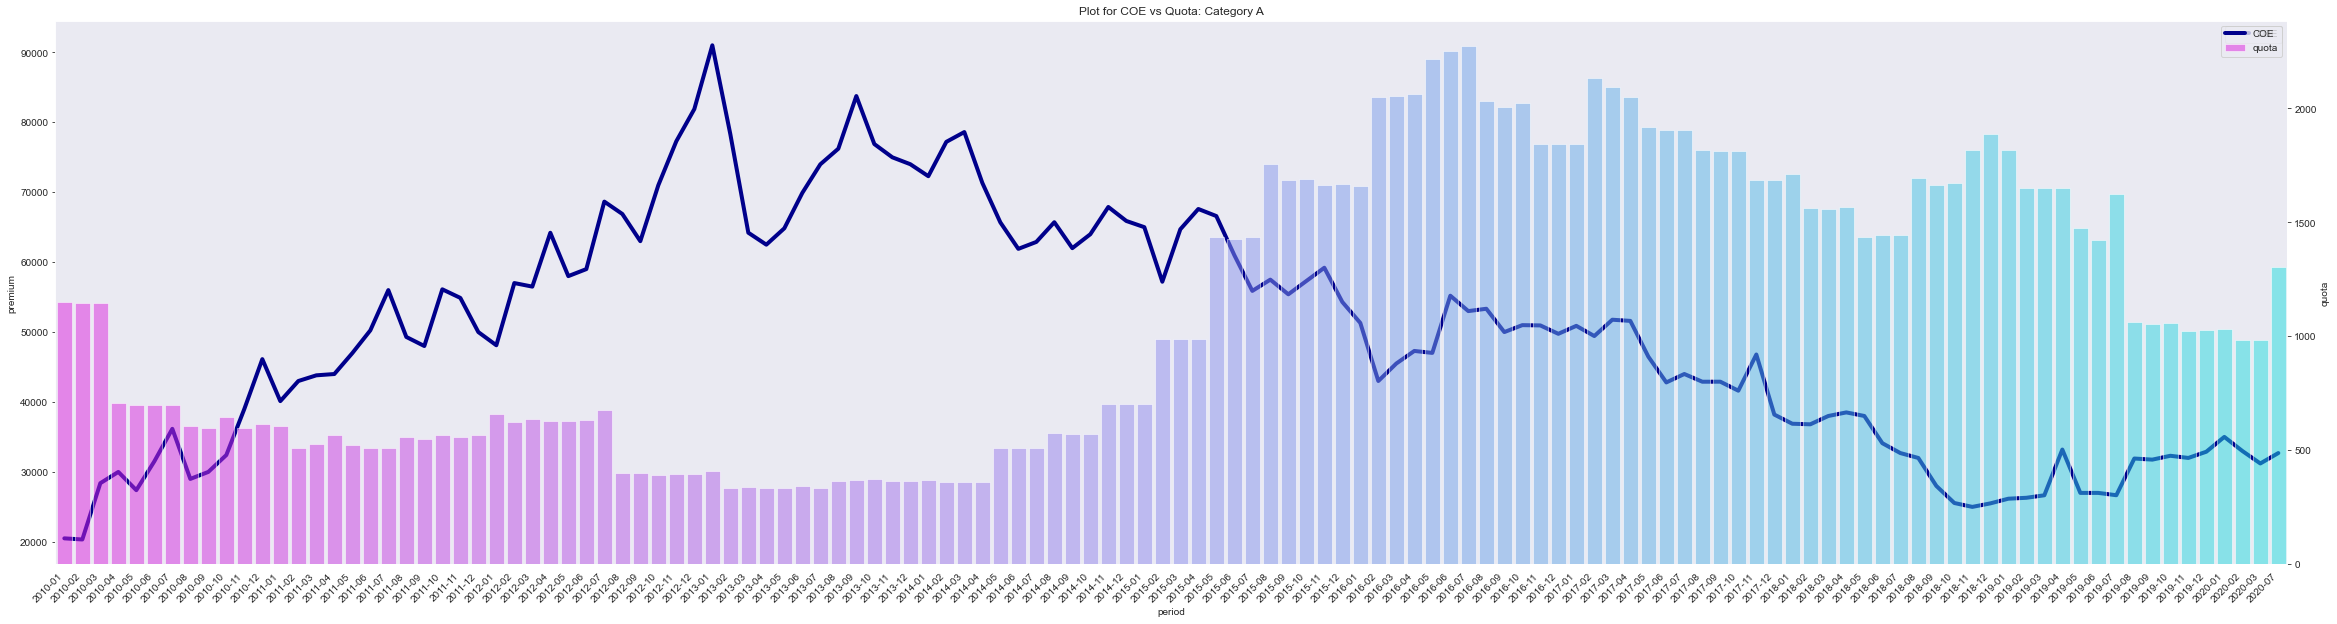

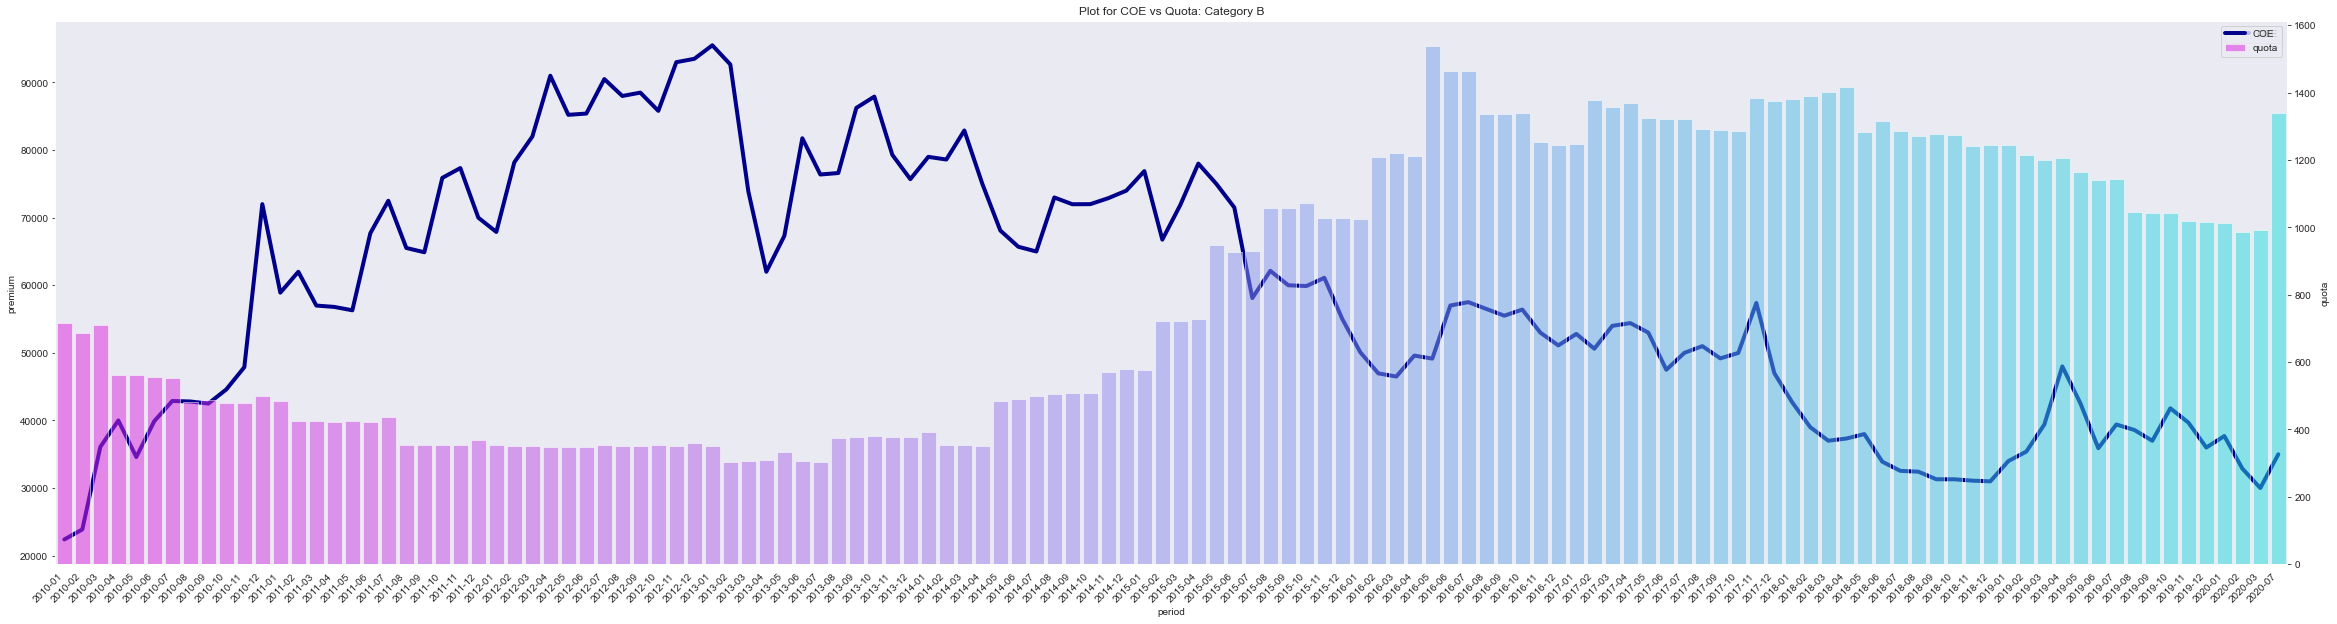

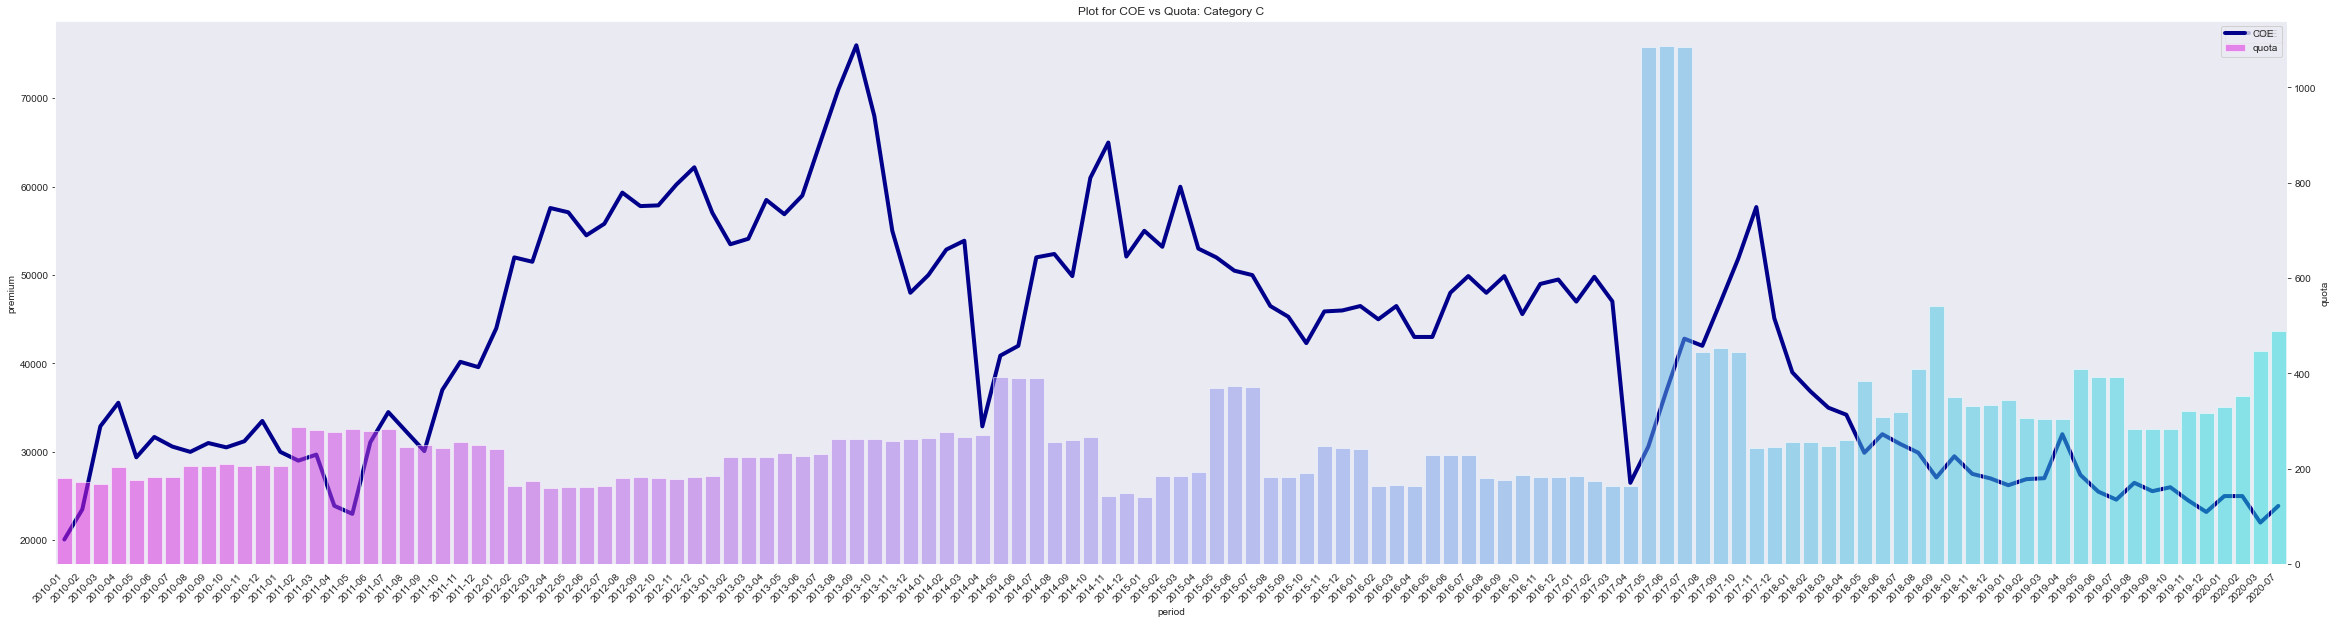

In [49]:
# Plotting COE against Quota
util.plot_target('Plot for COE vs Quota', coe_list, 'quota')

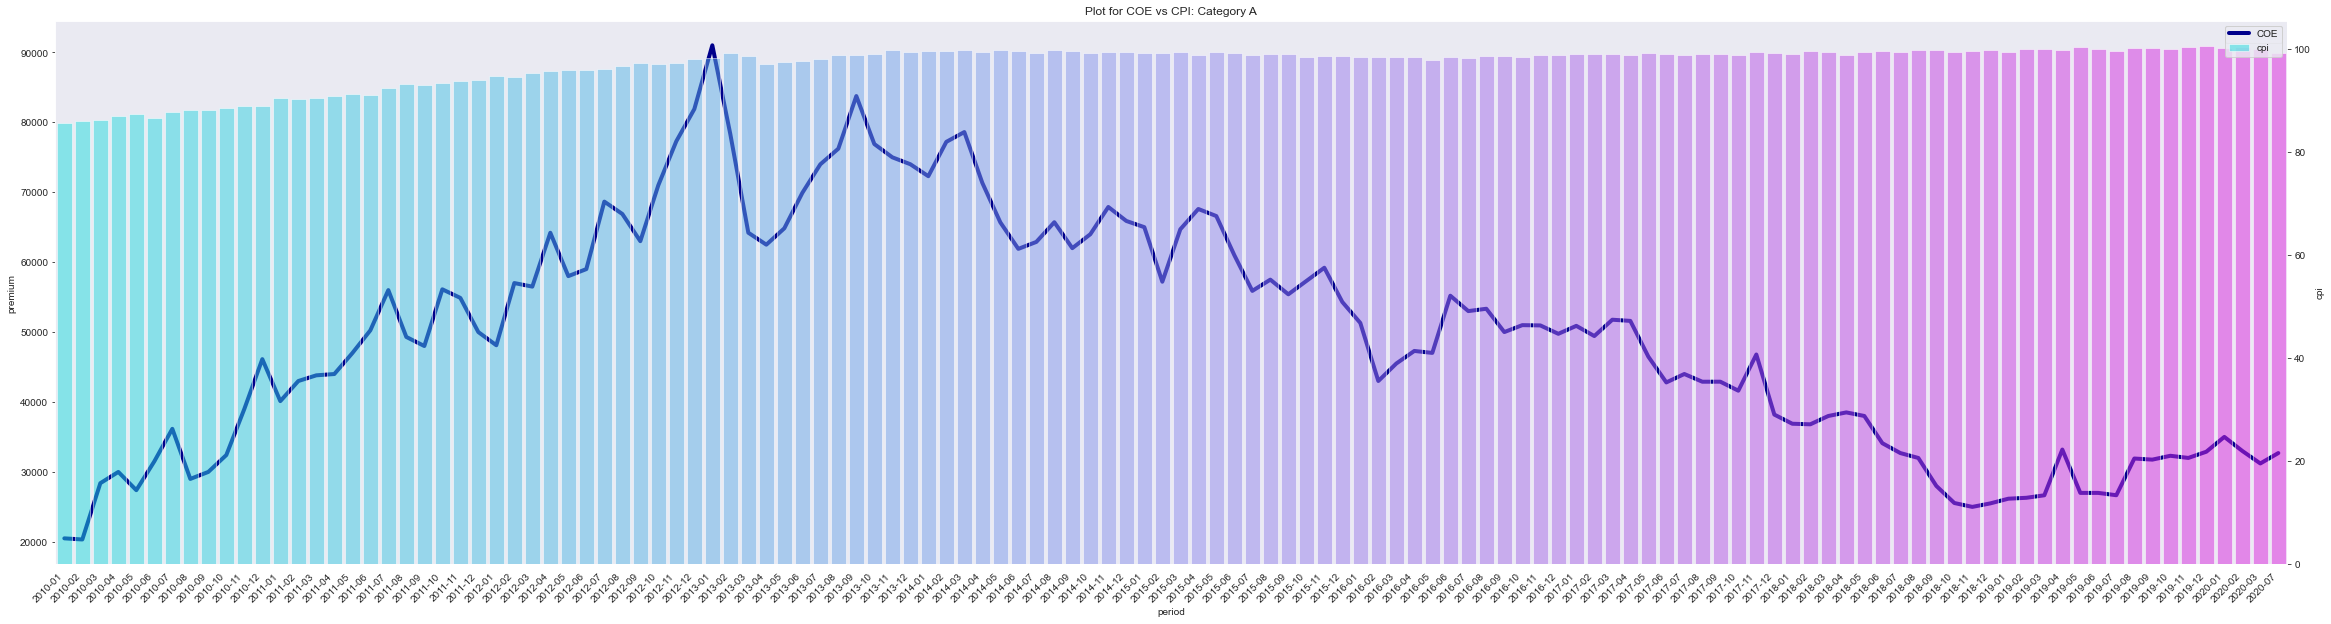

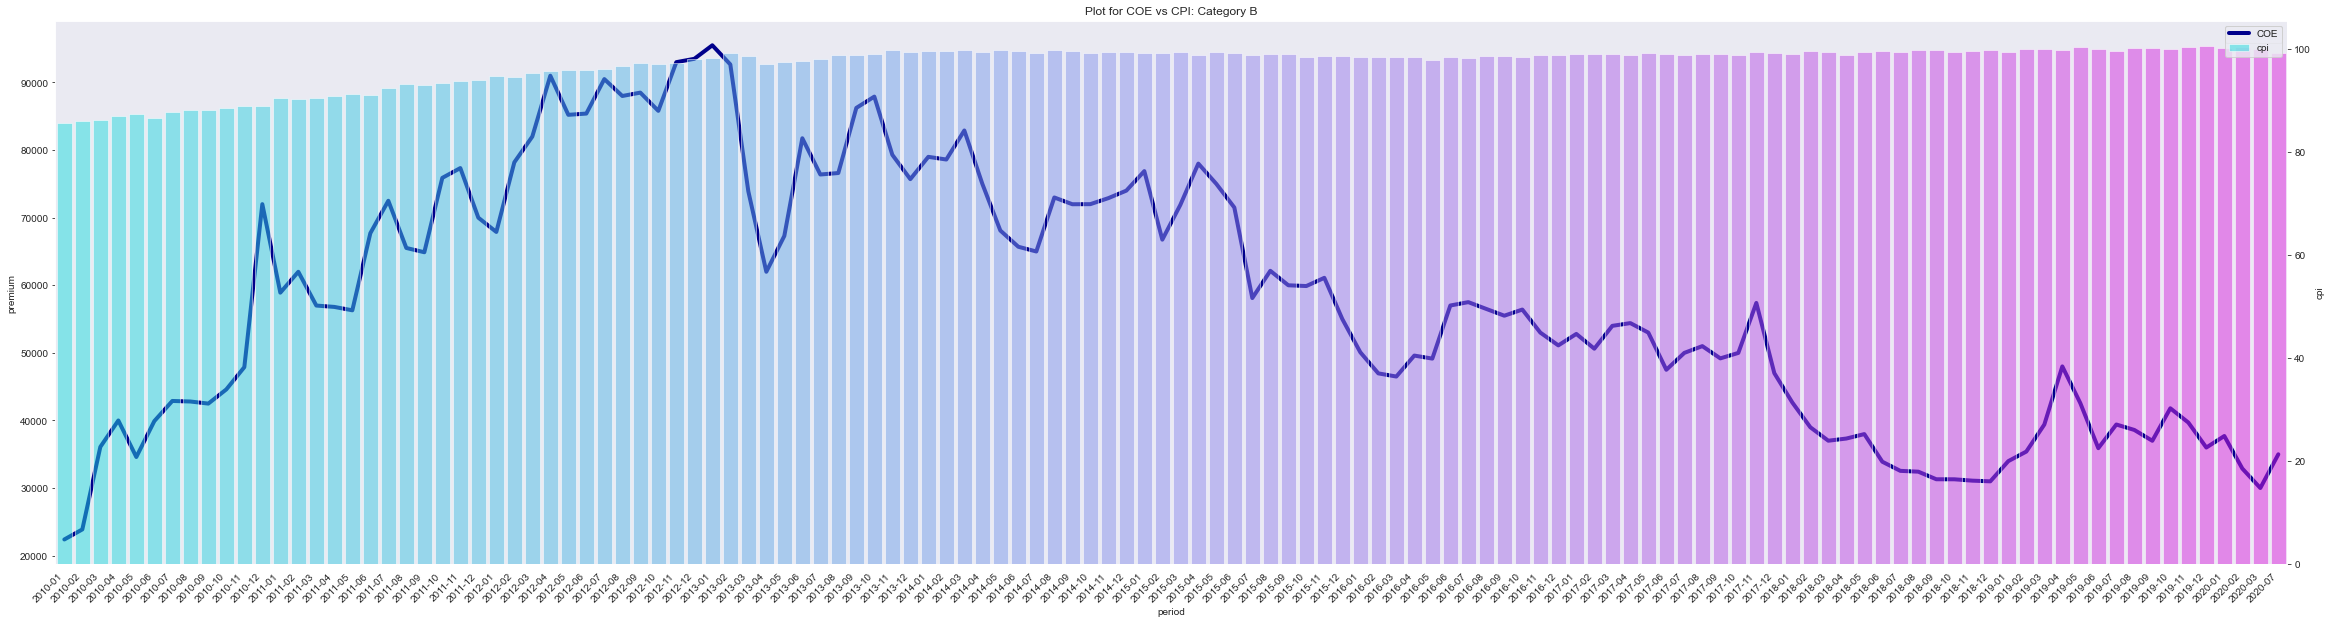

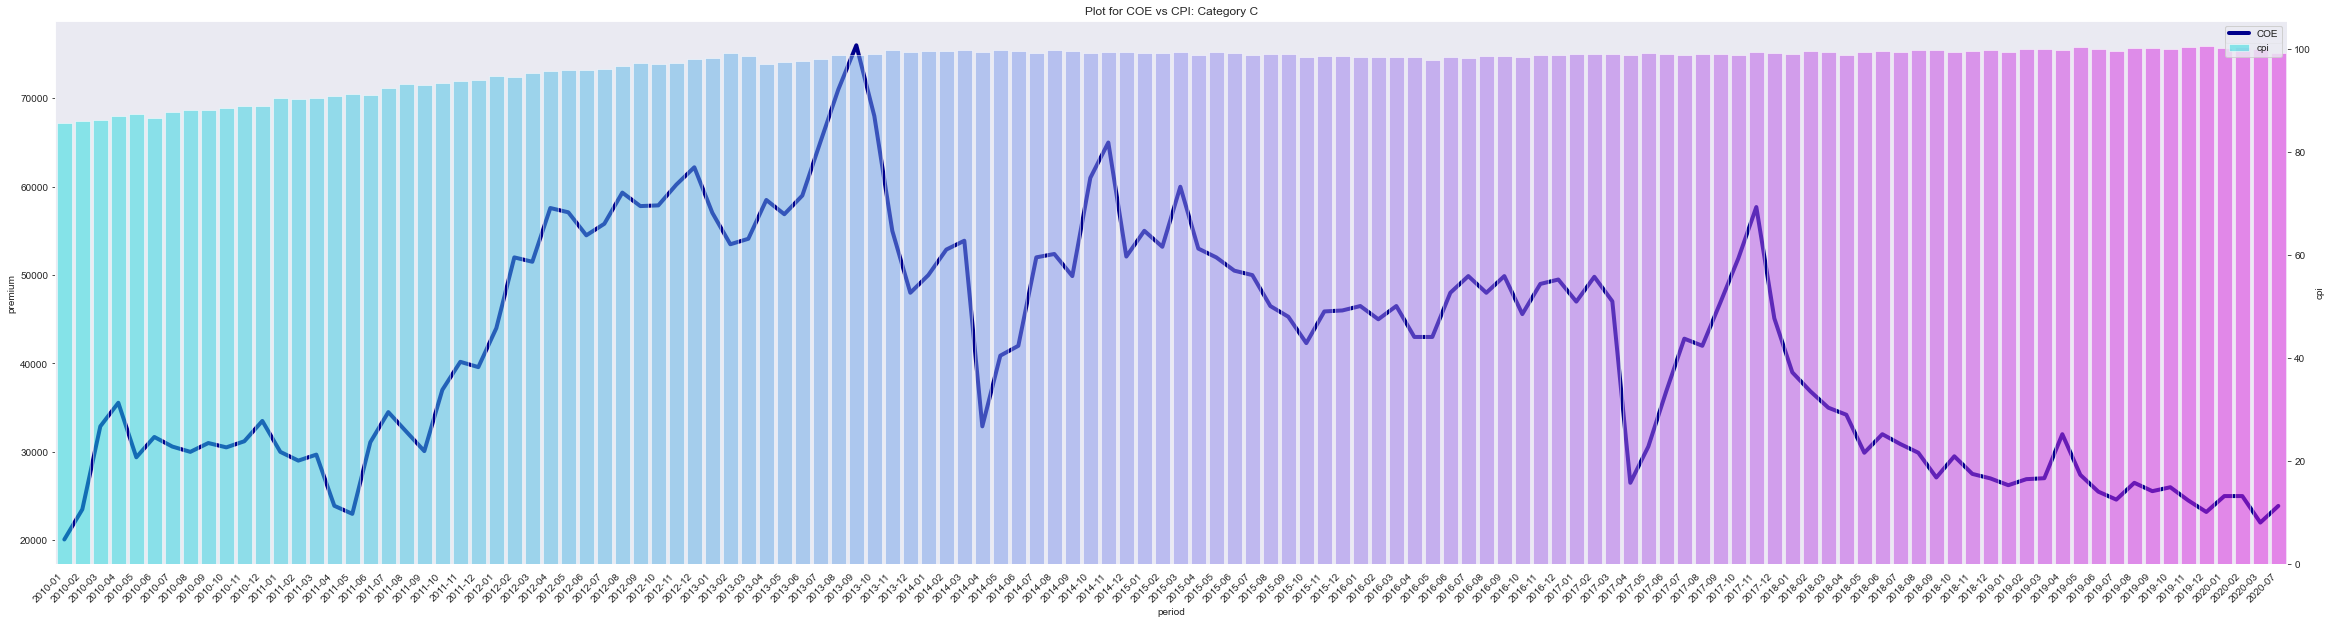

In [50]:
# Plotting COE against CPI
util.plot_target('Plot for COE vs CPI', coe_list, 'cpi', 'cool')

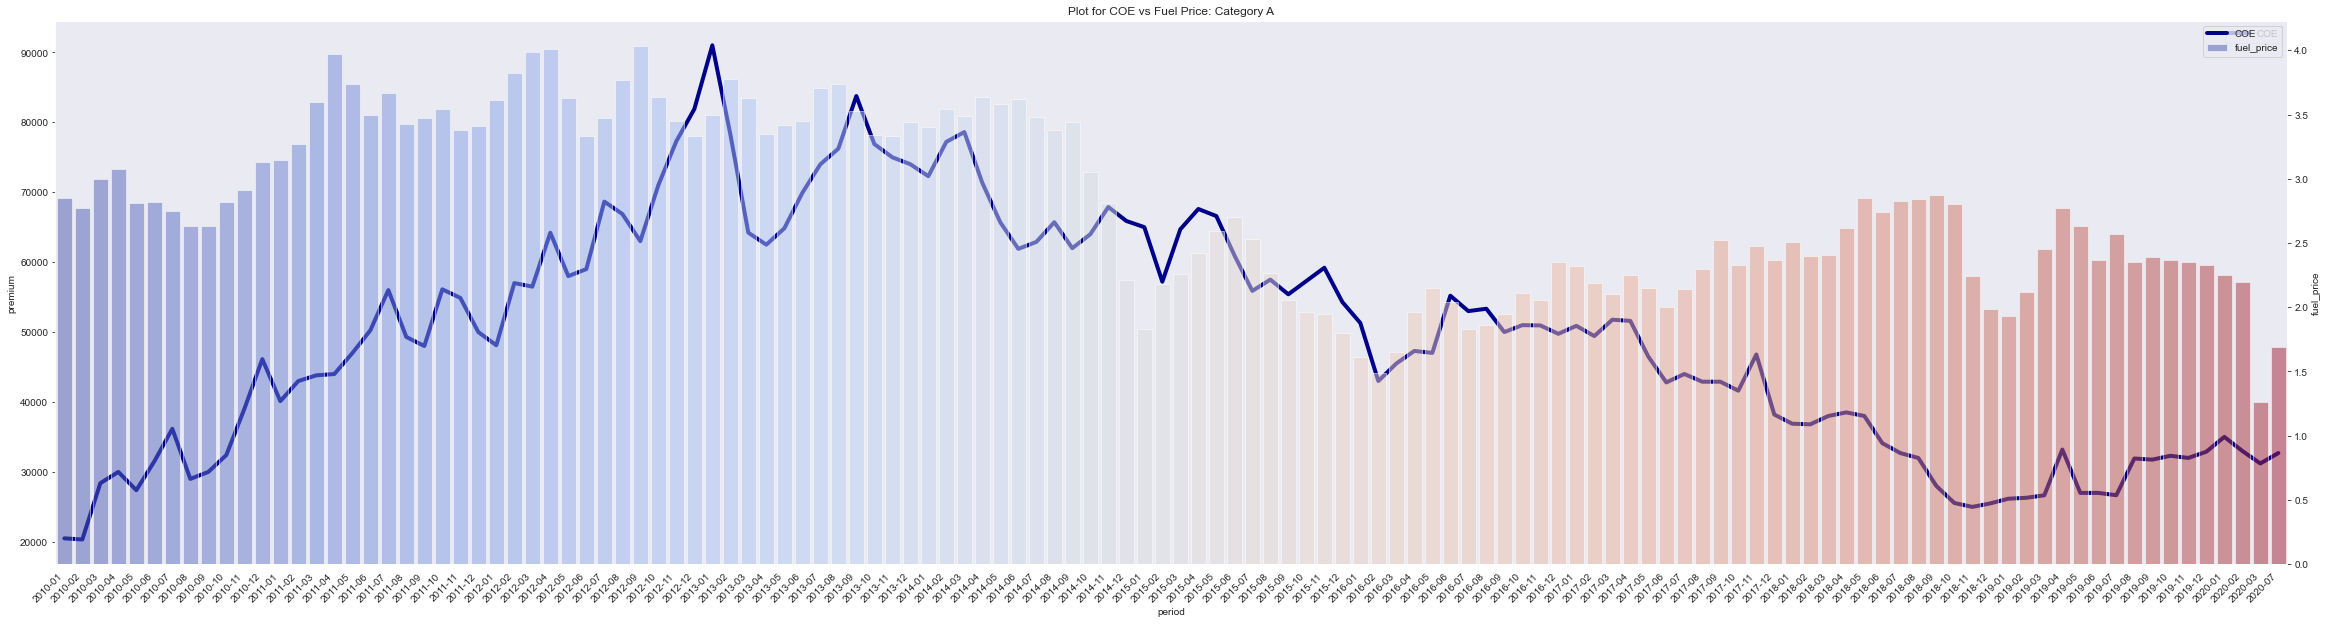

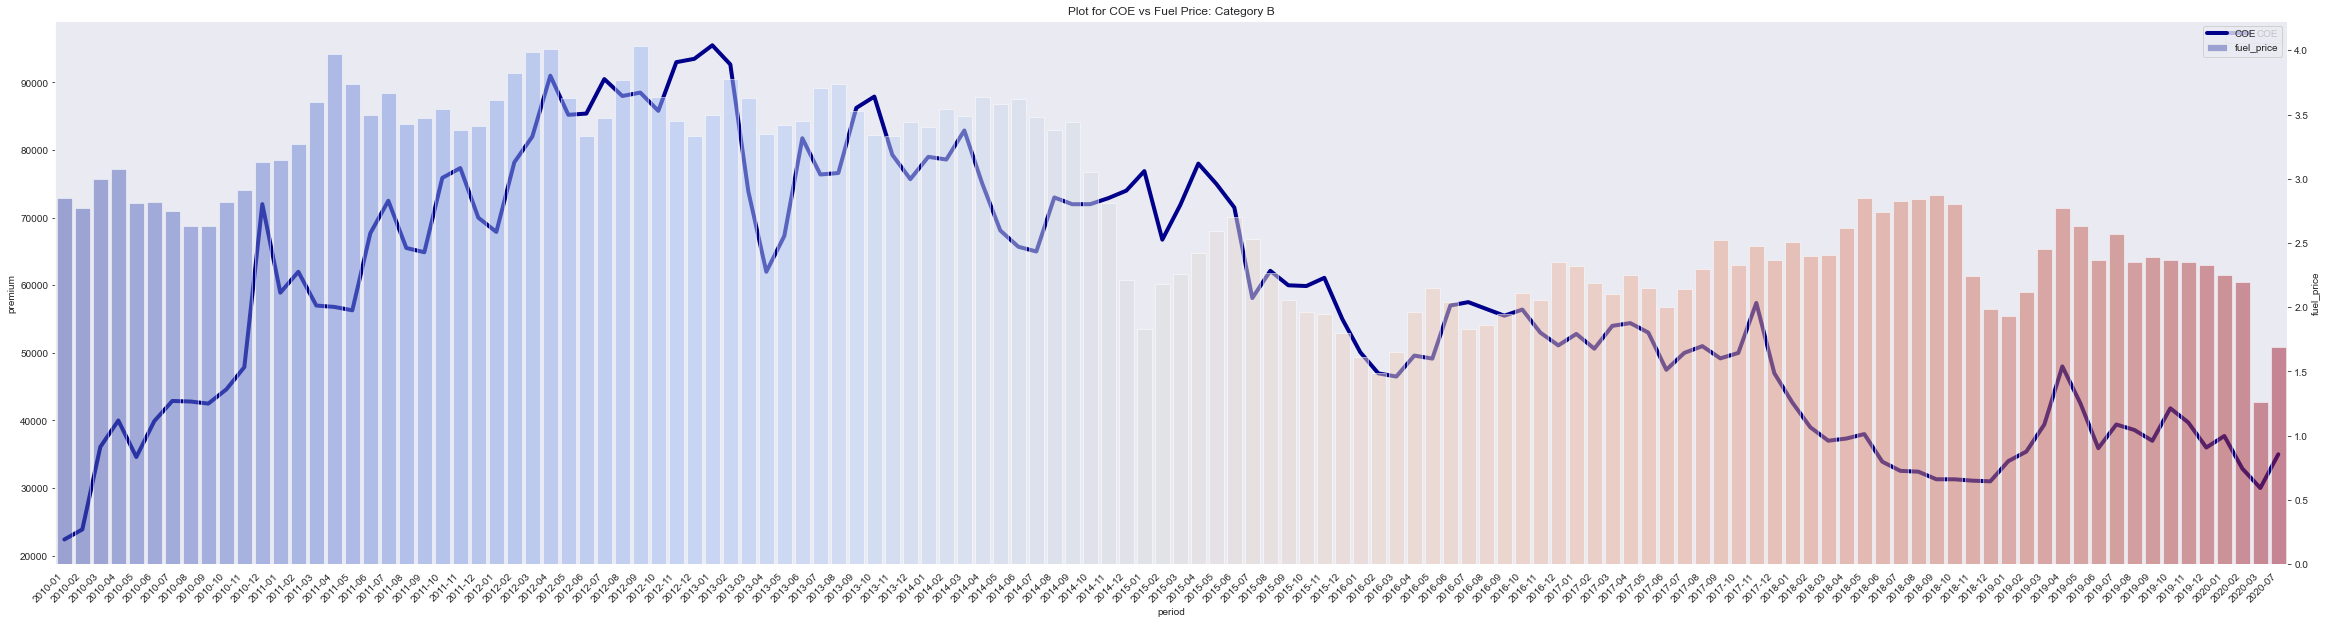

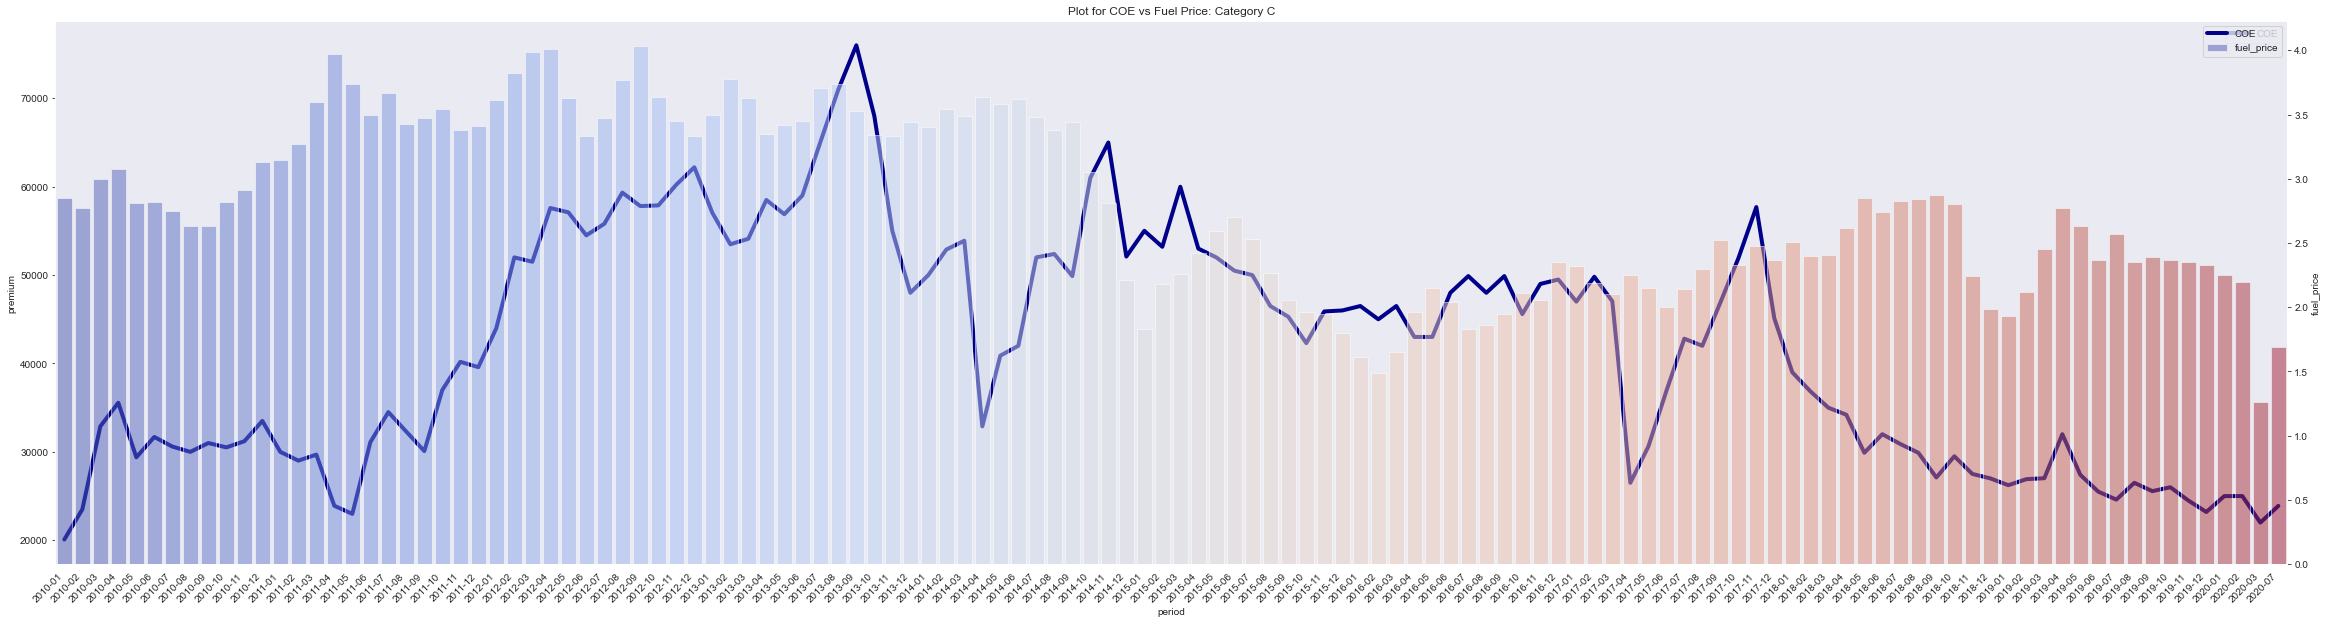

In [51]:
# Plotting COE against Fuel Price
util.plot_target('Plot for COE vs Fuel Price', coe_list, 'fuel_price', 'coolwarm')

In [52]:
logger.setLevel(logging.INFO)

In [53]:
cols = [ i for i in coe_list['Category A'].columns if not i.startswith('premium') ]
cols.remove('actuals')
cols.remove('vehicle_class')
cols.remove('period')
len(cols)

41

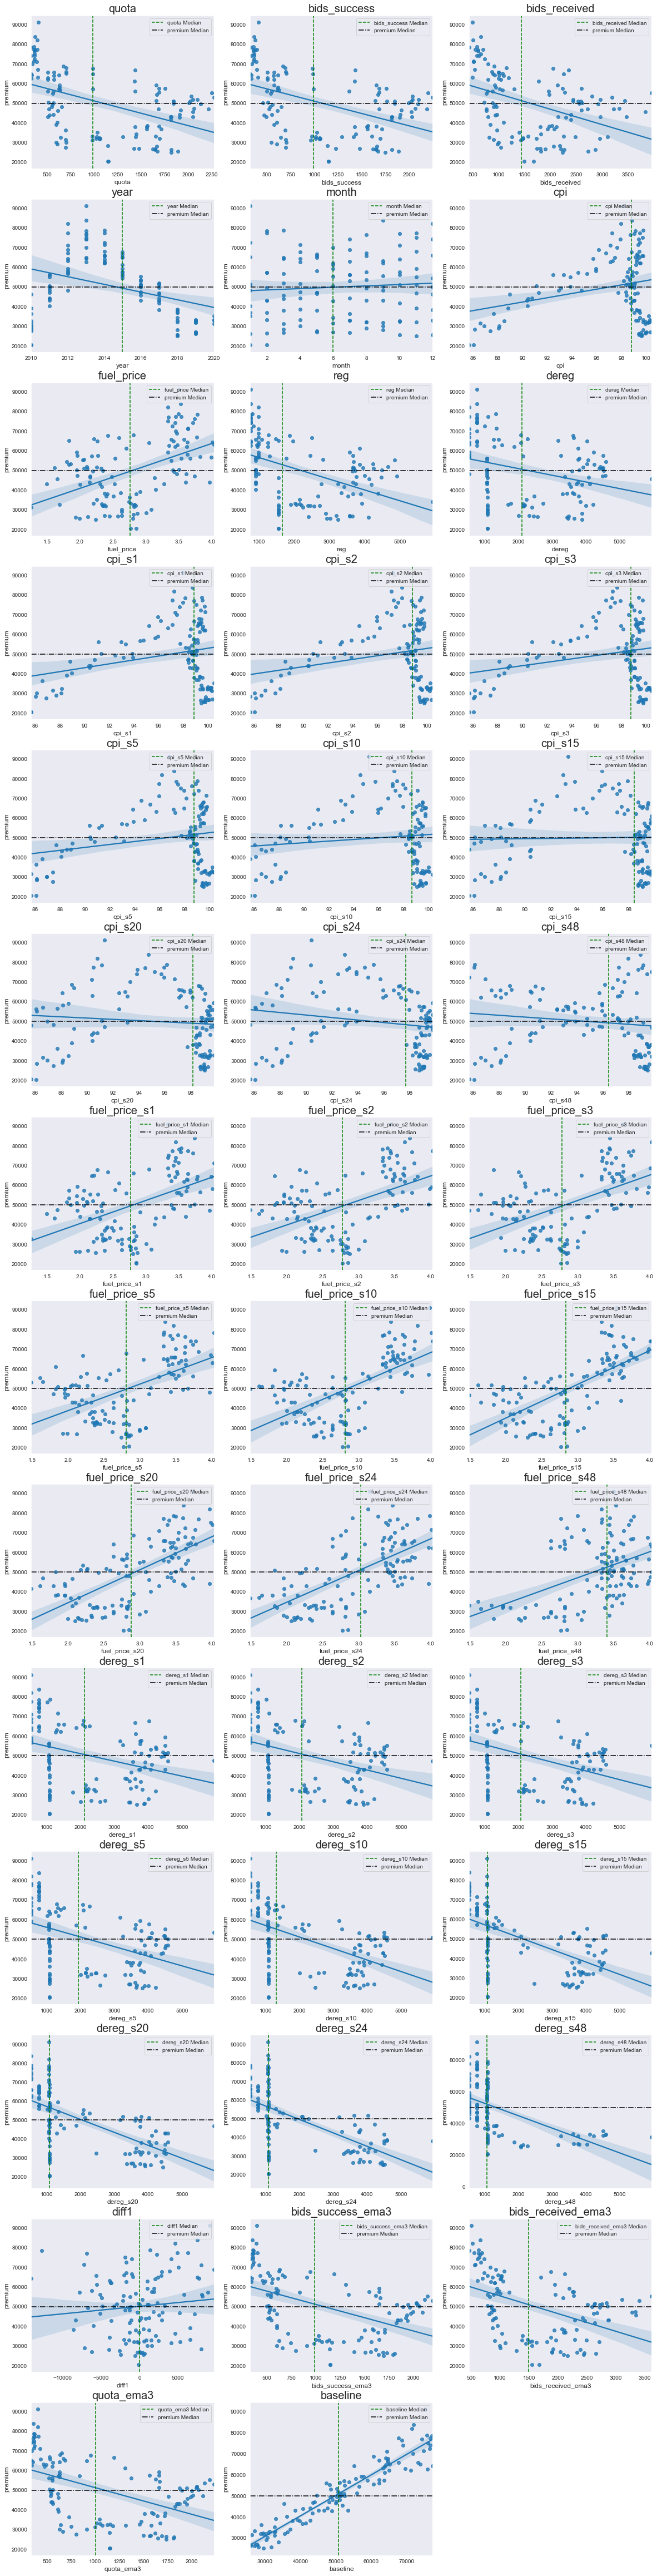

In [54]:
p = len(cols)
util.plot_scatter(coe_list['Category A'], 3, [ [c,'premium'] for c in cols ], cols, cols, ['premium']*p);

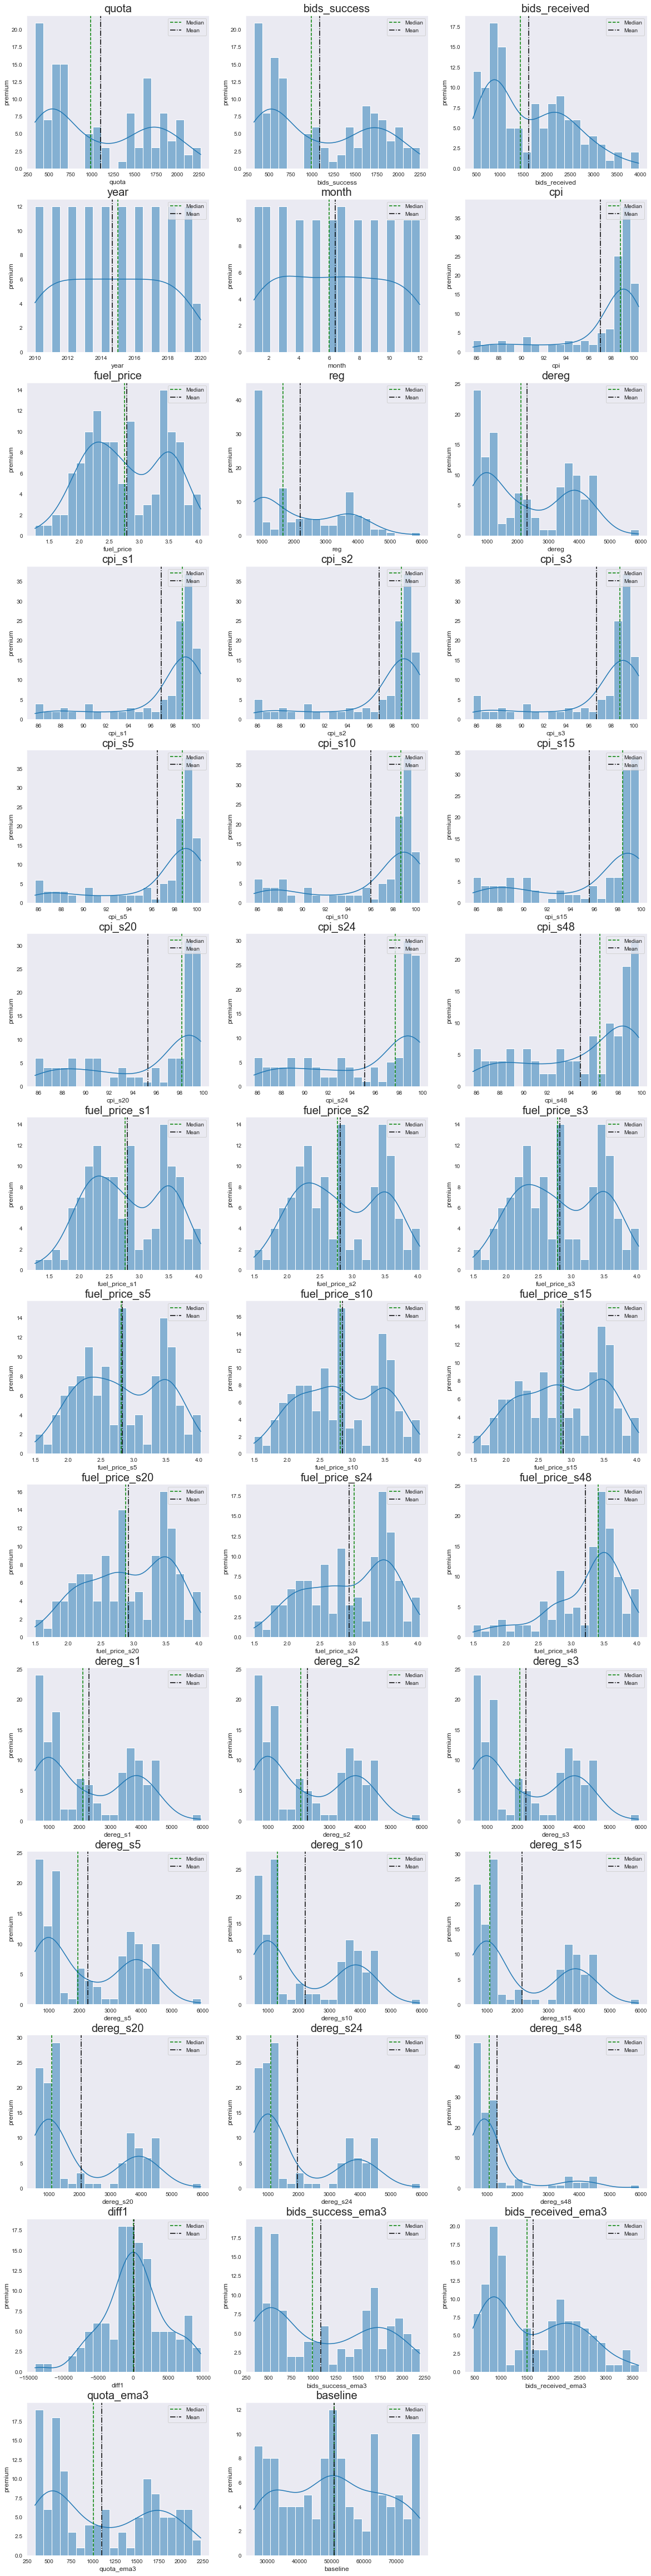

In [55]:
util.plot_hist(coe_list['Category A'], 3, cols, cols, cols, ['premium']*p)

In [56]:
plt.figure(figsize=(15,15))
catA = 'Category A'


<Figure size 1080x1080 with 0 Axes>

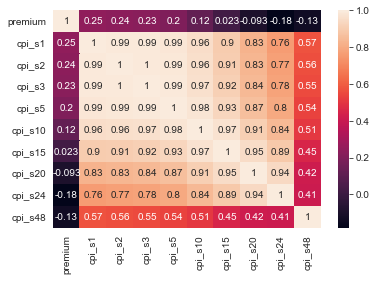

In [57]:
feats = ['premium', 'cpi_s1', 'cpi_s2', 'cpi_s3', 'cpi_s5', 'cpi_s10', 'cpi_s15', 'cpi_s20', 'cpi_s24', 'cpi_s48',]
sns.heatmap(coe_list[catA][feats].corr(), annot=True);

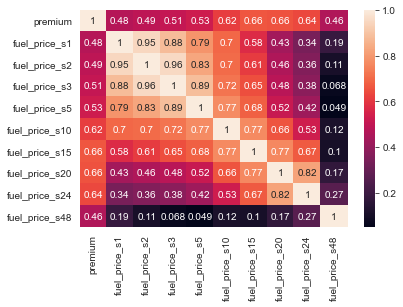

In [58]:
feats = ['premium', 'fuel_price_s1', 'fuel_price_s2', 'fuel_price_s3', 'fuel_price_s5', 
         'fuel_price_s10', 'fuel_price_s15', 'fuel_price_s20', 'fuel_price_s24', 'fuel_price_s48',]
sns.heatmap(coe_list[catA][feats].corr(), annot=True);

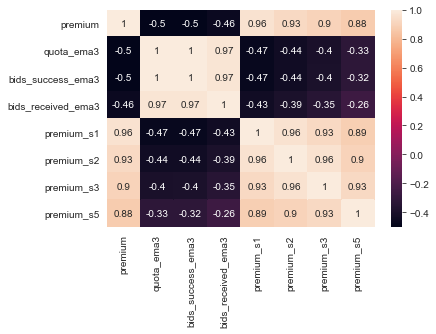

In [59]:
feats = ['premium', 'quota_ema3', 'bids_success_ema3', 'bids_received_ema3',
         'premium_s1', 'premium_s2', 'premium_s3', 'premium_s5',]
sns.heatmap(coe_list[catA][feats].corr(), annot=True);

---
## Time Series Analysis

Test Statistic   -1.8739
p-value           0.3445
dtype: float64
premium is not stationary as p-value of 0.3445 is > 0.05
shape for premium is (124,)


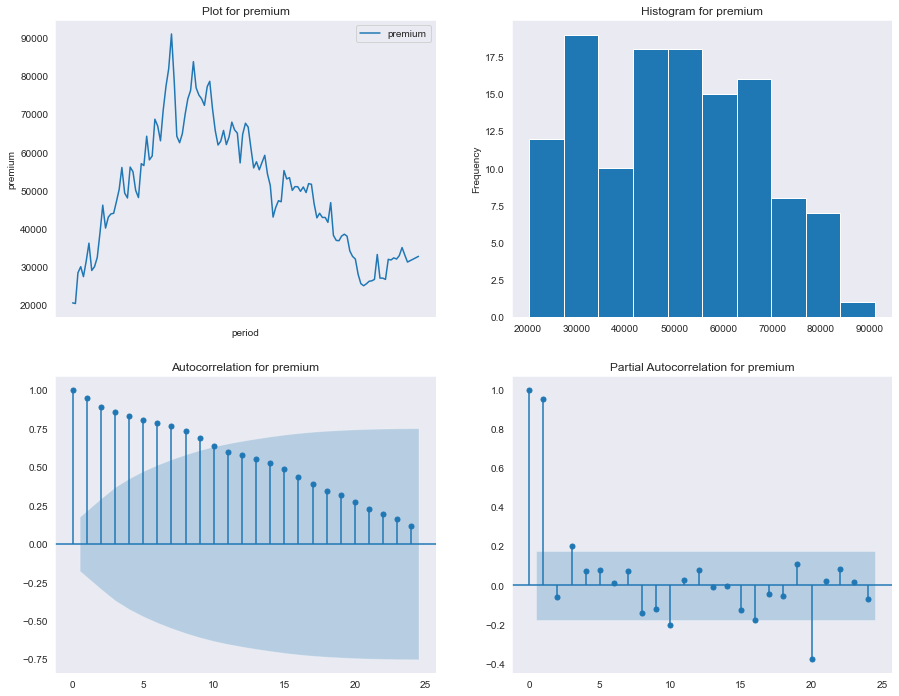

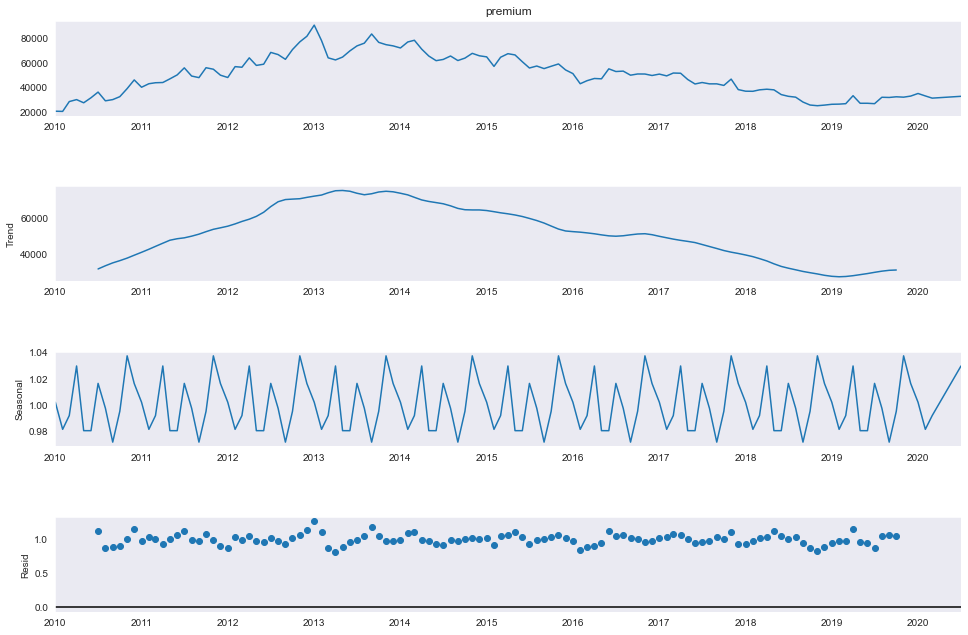

In [60]:
# Analysis of the target to check for autocorrection
catA = coe_list['Category A']
util.time_plots(catA, 'premium', 24, 'multiplicative')

Test Statistic   -7.0614e+00
p-value           5.2123e-10
dtype: float64
diff1 is stationary as p-value of 0.0000 is < 0.05
shape for diff1 is (123,)


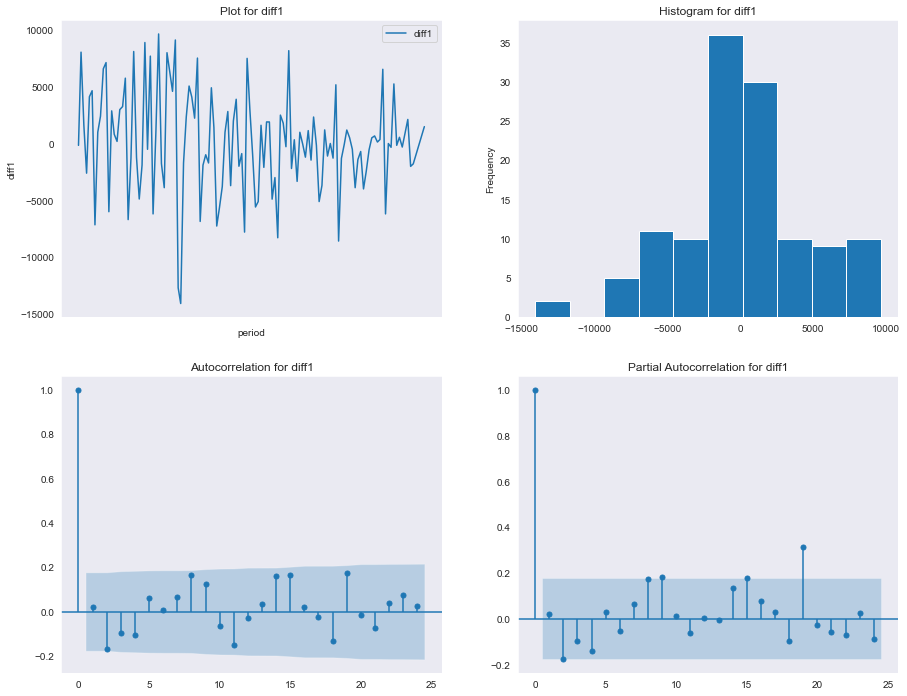

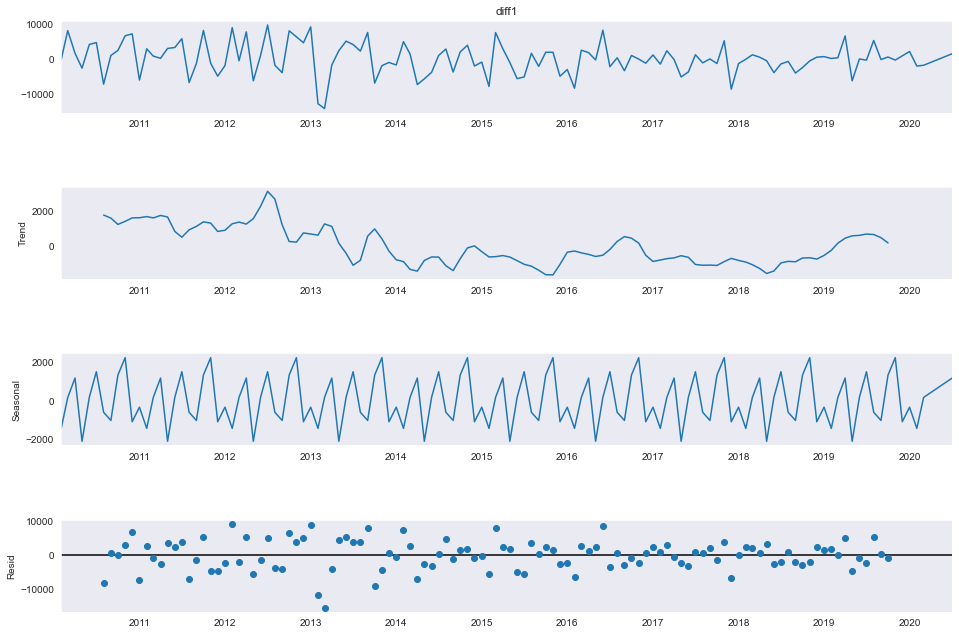

In [61]:
# Analysis of the diff1 on target to check for autocorrection
util.time_plots(catA, 'diff1', 24, 'additive')

In [62]:
# Splitting the data into Train and Test
trn_df = catA[catA['period']<'2019-01'].copy()
tst_df = catA[catA['period']>='2019-01'].copy()

print(f'train dataset shape: {trn_df.shape}')
print(f'test dataset shape: {tst_df.shape}')

train dataset shape: (108, 54)
test dataset shape: (16, 54)


In [63]:
GRIDSEARCH=False
# GridSearch ARIMA for best p and q (~5mins)
if GRIDSEARCH:
    logger.setLevel(logging.DEBUG)
    util.gs_arima(trn_df, tst_df)
    logger.setLevel(logging.INFO)

From the GridSearch above the optimal order is (0,0,2) <br>
However for our ARIMA prediction, we will be changing p to 1 after reviewing the acf and pacf charts.

2020-10-14 17:17:04 |INFO    | ARIMA RMSE:2780.3657


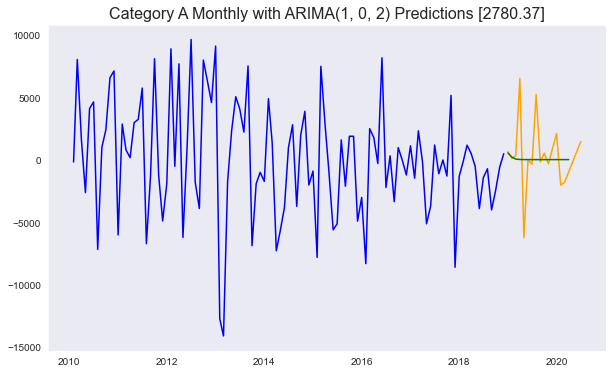

In [64]:
# Prediction with ARIMA
util.arima(trn_df, tst_df, (1,0,2))

---
## Modelling
In this section we will be using Linear regression and XGBoost regressor models to COE premium 

---
### Linear regression

In [65]:
# Create instance of DeployModel
dpm = dm.DeployModel();
dpm.set_df(coe_list)
dpm.set_shift(new_feats, shift)
dpm.set_target('premium')
dpm.insert_dates()

2020-10-14 17:17:04 |INFO    | date range from [min]:[2010-01-01] to [max]:[2020-07-01]
Category A: [Timestamp('2020-04-01 00:00:00'), Timestamp('2020-05-01 00:00:00'), Timestamp('2020-06-01 00:00:00')]
2020-10-14 17:17:04 |INFO    | date range from [min]:[2010-01-01] to [max]:[2020-07-01]
Category B: [Timestamp('2020-04-01 00:00:00'), Timestamp('2020-05-01 00:00:00'), Timestamp('2020-06-01 00:00:00')]
2020-10-14 17:17:04 |INFO    | date range from [min]:[2010-01-01] to [max]:[2020-07-01]
Category C: [Timestamp('2020-04-01 00:00:00'), Timestamp('2020-05-01 00:00:00'), Timestamp('2020-06-01 00:00:00')]


In [66]:
# features for linear regression
lr_feats = ['cpi_s1', 'cpi_s2', 'cpi_s3', 
            'fuel_price_s1', 'fuel_price_s2', 'fuel_price_s3',
            'cpi_s5', 'cpi_s10', 'cpi_s15', 'cpi_s20', 'cpi_s24', 'cpi_s48',
            'fuel_price_s5', 'fuel_price_s10', 'fuel_price_s15', 'fuel_price_s20',
            'fuel_price_s24', 'fuel_price_s48', 
            'quota_ema3', 'bids_success_ema3', 'bids_received_ema3',
            'premium_s1', 'premium_s2', 'premium_s3', 'premium_s5',
           ]
len(lr_feats)

25

In [67]:
dpm.set_feats('lr', lr_feats)
dpm.train_test_split('lr', '2019-01')
dpm.set_model('lr', LinearRegression())

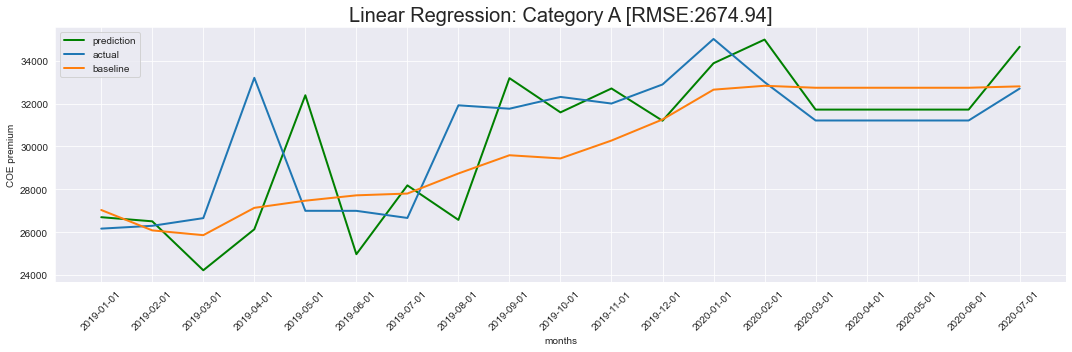

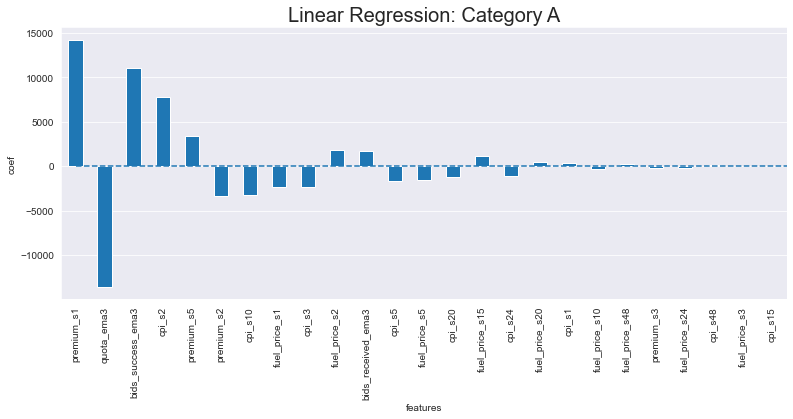

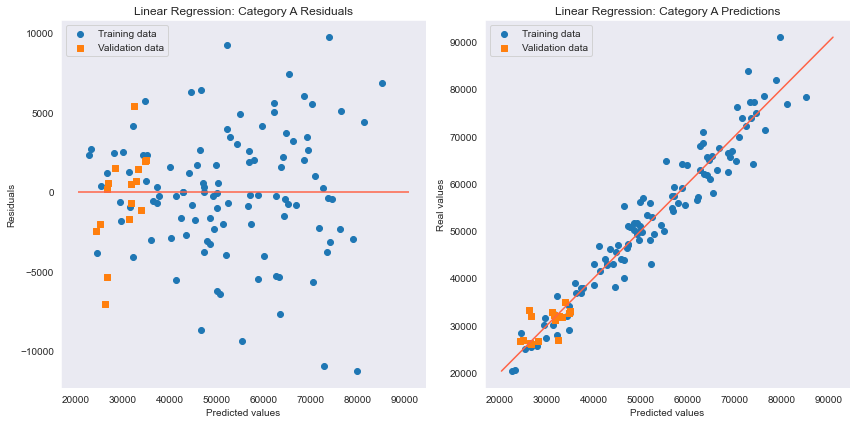

2020-10-14 17:17:05 |WARNING | Consider retraining the model. Last index in train data is 578 days 00:00:00
2020-10-14 17:17:05 |WARNING | Max of (pred-actual[5386.101672482582]) > 5000 for lr needs monitoring


In [68]:
# Linear Regression for Category A
lrA = dpm.modelling('lr','Category A')

In [69]:
# metrics for Category A Linear Regression
results = lrA['results']
metrics = lrA['metrics']
display(pd.DataFrame(metrics))

lrA
01 Train R2        0.9351
02 Test R2         0.0680
03 Train RMSE  3,948.7210
04 Test RMSE   2,674.9417
05 Base RMSE   2,100.0304
06 Test CV        -1.5745

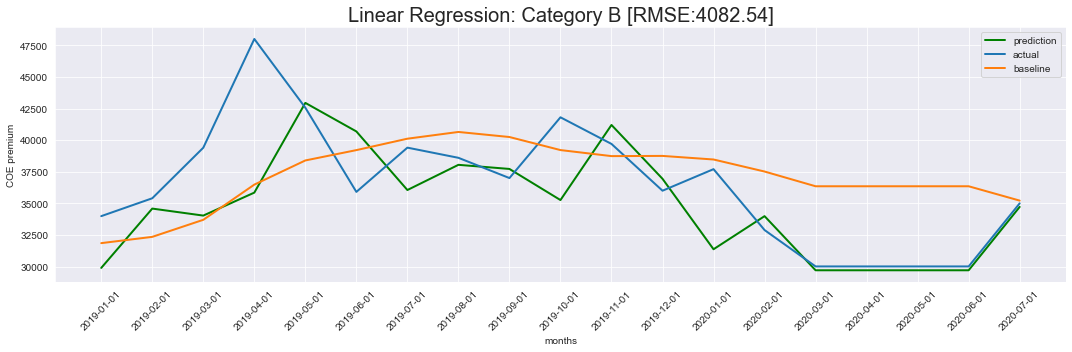

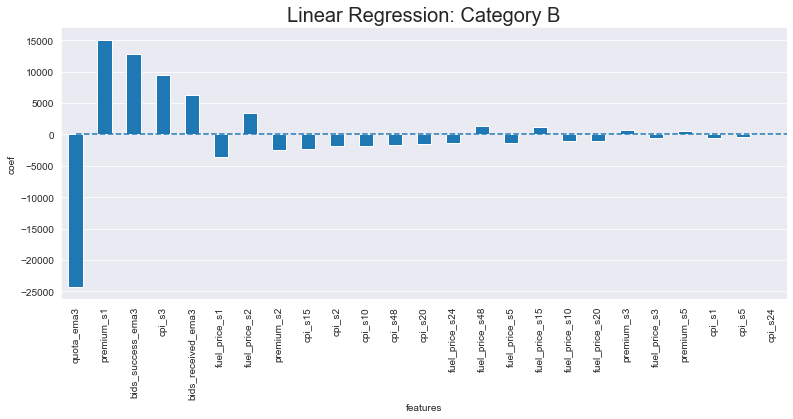

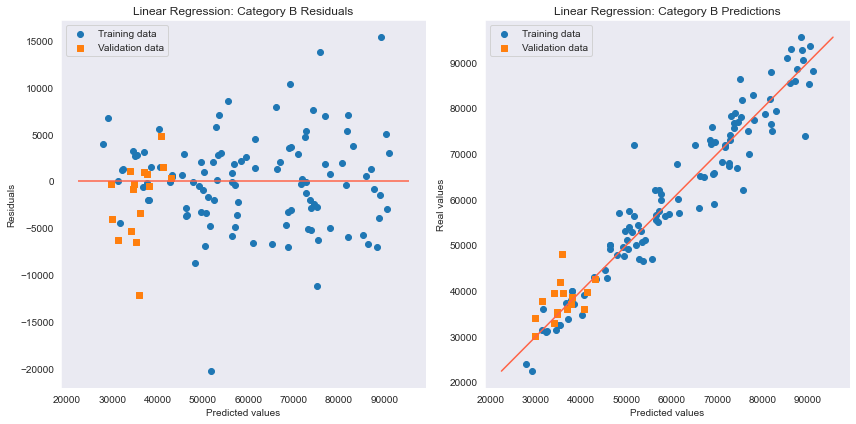

2020-10-14 17:17:06 |WARNING | Consider retraining the model. Last index in train data is 578 days 00:00:00


In [70]:
# Linear Regression for Category B
lrB = dpm.modelling('lr','Category B')

In [71]:
# metrics for Category B Linear Regression
results.update(lrB['results'])
metrics.update(lrB['metrics'])
display(pd.DataFrame(metrics))

lrA         lrB
01 Train R2        0.9351      0.9225
02 Test R2         0.0680      0.2499
03 Train RMSE  3,948.7210  4,971.4185
04 Test RMSE   2,674.9417  4,082.5381
05 Base RMSE   2,100.0304  4,704.9978
06 Test CV        -1.5745     -1.0743

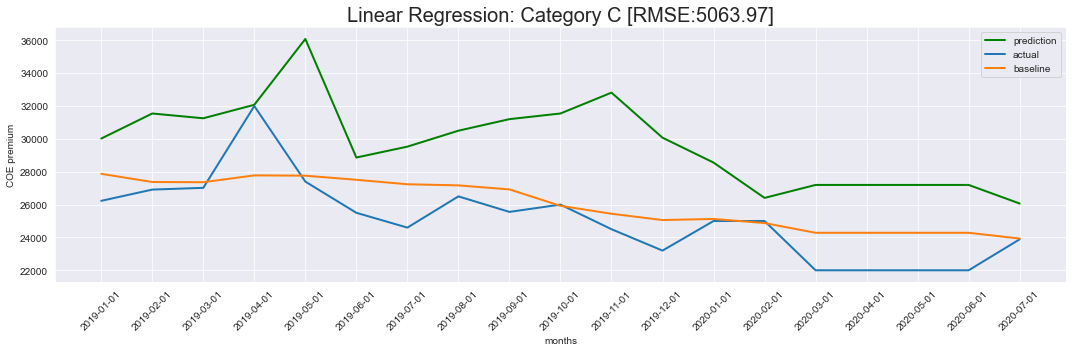

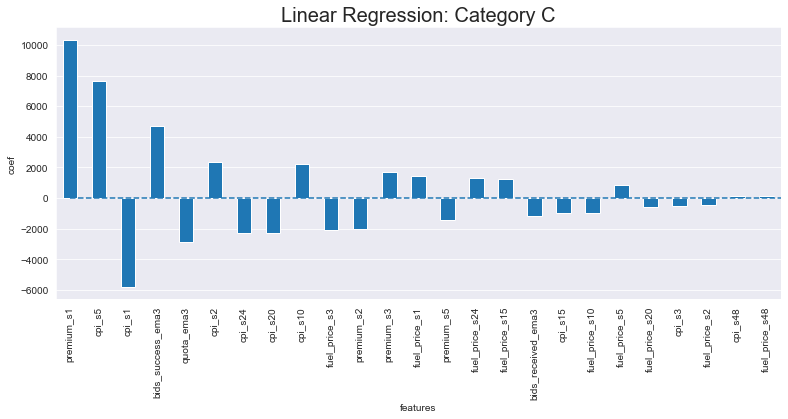

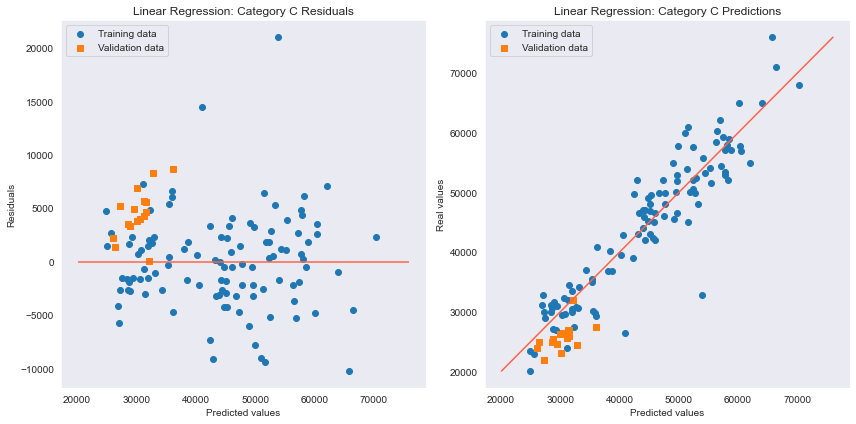

2020-10-14 17:17:06 |WARNING | Consider retraining the model. Last index in train data is 578 days 00:00:00
2020-10-14 17:17:06 |WARNING | Max of (pred-actual[8684.07149525387]) > 5000 for lr needs monitoring


In [72]:
# Linear Regression for Category C
lrC = dpm.modelling('lr','Category C')

In [73]:
# metrics for Category C Linear Regression
results.update(lrC['results'])
metrics.update(lrC['metrics'])
display(pd.DataFrame(metrics))

lrA         lrB         lrC
01 Train R2        0.9351      0.9225      0.8619
02 Test R2         0.0680      0.2499     -3.4946
03 Train RMSE  3,948.7210  4,971.4185  4,458.7876
04 Test RMSE   2,674.9417  4,082.5381  5,063.9657
05 Base RMSE   2,100.0304  4,704.9978  1,770.3585
06 Test CV        -1.5745     -1.0743    -12.3922

---
### XGBoost regressor

In [74]:
# features for Category A XGBoost regressor
xgb_feats = ['cpi_s1', 'cpi_s2', 'cpi_s3', 'fuel_price_s1', 'fuel_price_s2', 
             'fuel_price_s3', 'cpi_s5', 'cpi_s10', 'cpi_s15', 'cpi_s20', 'cpi_s24', 
             'cpi_s48', 'fuel_price_s5', 'fuel_price_s10', 'fuel_price_s15', 
             'fuel_price_s20', 'fuel_price_s24', 'fuel_price_s48', 'year',
             'quota_ema3', 'bids_success_ema3', 'bids_received_ema3',
             'dereg_s1', 'dereg_s2',
            ]
dpm.set_feats('xgbA', xgb_feats)
logger.info(f'Category A: number of features {len(xgb_feats)}')

2020-10-14 17:17:06 |INFO    | Category A: number of features 24


In [75]:
# features for Category B XGBoost regressor
xgb_feats = ['cpi_s1', 'cpi_s2', 'cpi_s3', 'fuel_price_s1', 'fuel_price_s2', 
             'fuel_price_s3', 'cpi_s5', 'cpi_s10', 'cpi_s15', 'cpi_s20', 'cpi_s24', 
             'cpi_s48', 'fuel_price_s5', 'fuel_price_s10', 'fuel_price_s15', 
             'fuel_price_s20', 'fuel_price_s24', 'fuel_price_s48', 'year',
             'quota_ema3', 'bids_success_ema3', 'bids_received_ema3', 'dereg_s1', 
             'premium_s1', 'premium_s2', 'premium_s3', 'premium_s5',
            ]
dpm.set_feats('xgbB', xgb_feats)
logger.info(f'Category B: number of features {len(xgb_feats)}')

2020-10-14 17:17:06 |INFO    | Category B: number of features 27


In [76]:
# features for Category C XGBoost regressor
xgb_feats = ['cpi_s1', 'cpi_s2', 'cpi_s3', 'fuel_price_s1', 'fuel_price_s2', 
             'fuel_price_s3', 'cpi_s5', 'cpi_s10', 'cpi_s15', 'cpi_s20', 'cpi_s24', 
             'cpi_s48', 'fuel_price_s5', 'fuel_price_s10', 'fuel_price_s15', 
             'fuel_price_s20', 'fuel_price_s24', 'fuel_price_s48', 'year', 'month',
             'quota_ema3', 'bids_success_ema3', 'bids_received_ema3',
             'premium_s1', 'premium_s2', 'premium_s3', 'premium_s5',
            ]
dpm.set_feats('xgbC', xgb_feats)
logger.info(f'Category C: number of features {len(xgb_feats)}')

2020-10-14 17:17:06 |INFO    | Category C: number of features 27


In [77]:
# Train test split the xgb set of data
dpm.train_test_split('xgb', '2019-01')

#### GridSearch for best XGBoost regressor hyperparameters

In [78]:
# Creating a pipeline model XGBoost Regressor for GridSearch
xgb_pipe = Pipeline([
        ('xgb', XGBRegressor(random_state=42, 
                              objective='reg:squarederror', 
                              verbosity=1, n_jobs=-1))
    ])
# XGBoost Regressor Parameters for GridSearch
xgb_params = {  'xgb__learning_rate': [0.05, 0.1],
                'xgb__max_depth': [3, 4, 5],
                'xgb__min_child_weight': [4, 5, 6],
                'xgb__gamma': [0.7, 0.8],
                'xgb__subsample': [ 0.8, 0.9],
                'xgb__n_estimators': [300, 400, 500]}

In [79]:
GRIDSEARCH=False
# GridSearch to find the best hyperparameter (~45mins)
if GRIDSEARCH:
    logger.setLevel(logging.DEBUG)
    for cat in coe_list.keys():
        gs = GridSearchCV(xgb_pipe, param_grid=xgb_params, cv=5, scoring='neg_root_mean_squared_error')
        gs.fit(dpm.split_df['xgb'][cat]['X_trn_sc'], dpm.split_df['xgb'][cat]['y_train'])
        logger.debug(f"XGBoost for {cat} best_params:\n{gs.best_params_}")
    logger.setLevel(logging.INFO)

After GridSearch, next we will start to create instances of XGBoost Regressors with the best parameters for each category

In [80]:
# XGBRegressor is fitted with GridSearch parameters
dpm.set_model('xgbA', XGBRegressor(
    objective='reg:squarederror',
    gamma=0.7,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=6,
    n_estimators=400,
    subsample=0.8
))

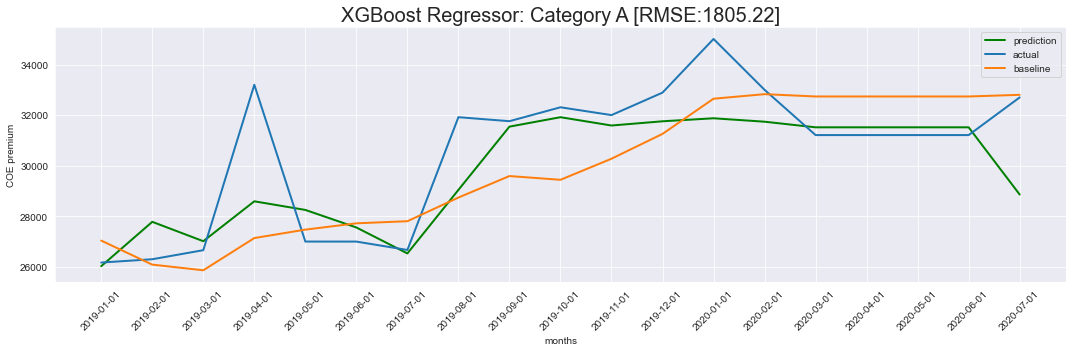

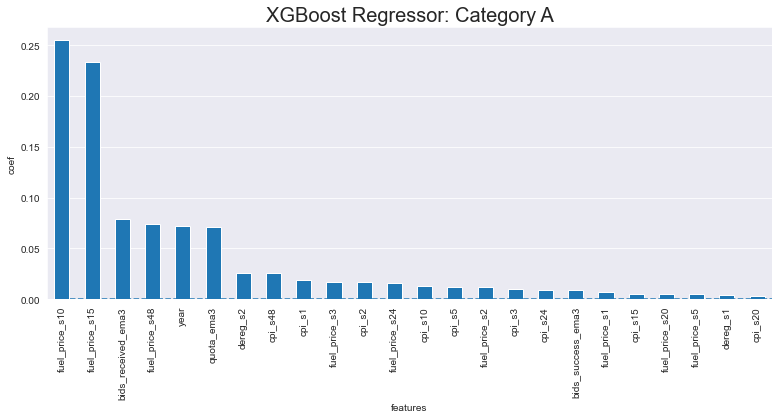

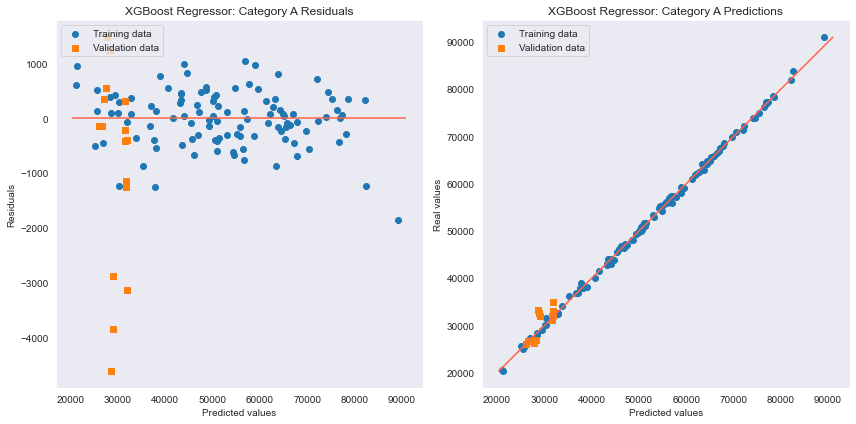

2020-10-14 17:17:08 |WARNING | Consider retraining the model. Last index in train data is 578 days 00:00:00


In [81]:
# XGBoost Regressor for Category A
xgbA = dpm.modelling('xgb','Category A')

In [82]:
# metrics for Category A XGBoost Regressor
results.update(xgbA['results'])
metrics.update(xgbA['metrics'])
display(pd.DataFrame(metrics))

lrA         lrB         lrC        xgbA
01 Train R2        0.9351      0.9225      0.8619      0.9989
02 Test R2         0.0680      0.2499     -3.4946      0.5755
03 Train RMSE  3,948.7210  4,971.4185  4,458.7876    508.6091
04 Test RMSE   2,674.9417  4,082.5381  5,063.9657  1,805.2177
05 Base RMSE   2,100.0304  4,704.9978  1,770.3585  2,100.0304
06 Test CV        -1.5745     -1.0743    -12.3922     -1.6776

In [83]:
# XGBRegressor is fitted with GridSearch parameters
dpm.set_model('xgbB', XGBRegressor(
    objective='reg:squarederror',
    gamma=0.7,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=4,
    n_estimators=500,
    subsample=0.7
))

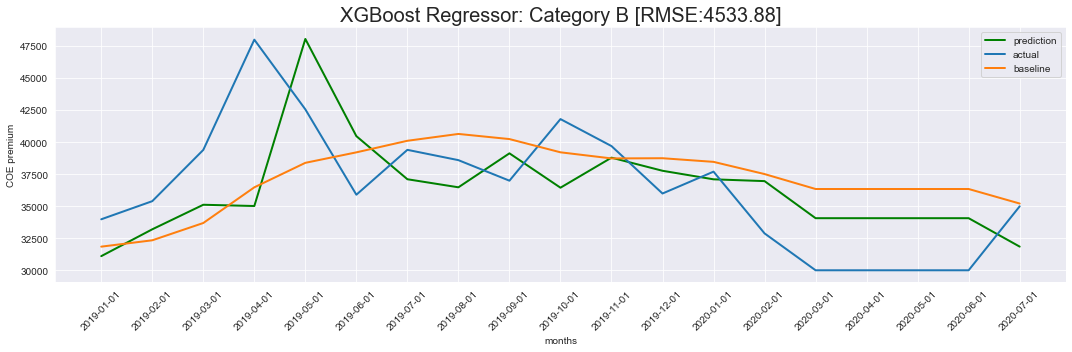

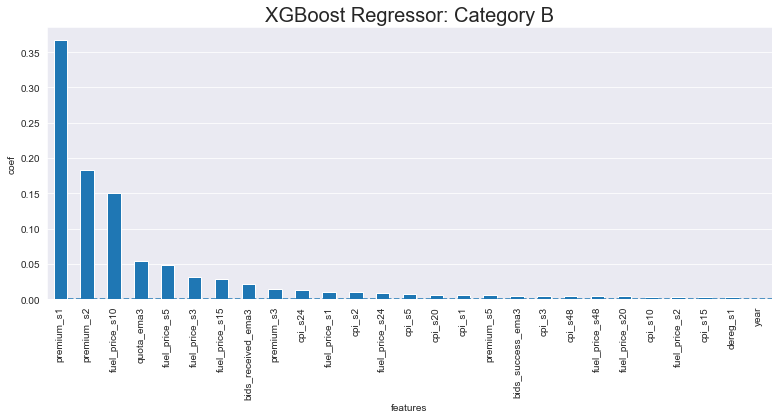

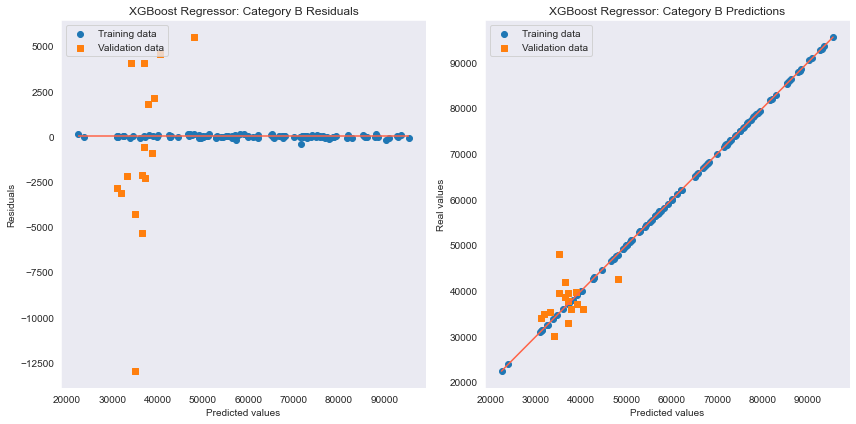

2020-10-14 17:17:09 |WARNING | Consider retraining the model. Last index in train data is 578 days 00:00:00
2020-10-14 17:17:09 |WARNING | Max of (pred-actual[5490.6484375]) > 5000 for xgbB needs monitoring


In [84]:
# XGBoost Regressor for Category B
xgbB = dpm.modelling('xgb','Category B')

In [85]:
# metrics for Category B XGBoost Regressor
results.update(xgbB['results'])
metrics.update(xgbB['metrics'])
display(pd.DataFrame(metrics))

lrA         lrB         lrC        xgbA        xgbB
01 Train R2        0.9351      0.9225      0.8619      0.9989      1.0000
02 Test R2         0.0680      0.2499     -3.4946      0.5755      0.0748
03 Train RMSE  3,948.7210  4,971.4185  4,458.7876    508.6091     77.6849
04 Test RMSE   2,674.9417  4,082.5381  5,063.9657  1,805.2177  4,533.8845
05 Base RMSE   2,100.0304  4,704.9978  1,770.3585  2,100.0304  4,704.9978
06 Test CV        -1.5745     -1.0743    -12.3922     -1.6776     -0.8324

In [86]:
# XGBRegressor is fitted with GridSearch parameters
dpm.set_model('xgbC', XGBRegressor(
    objective='reg:squarederror',
    gamma=0.7,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=6,
    n_estimators=400,
    subsample=0.7
))

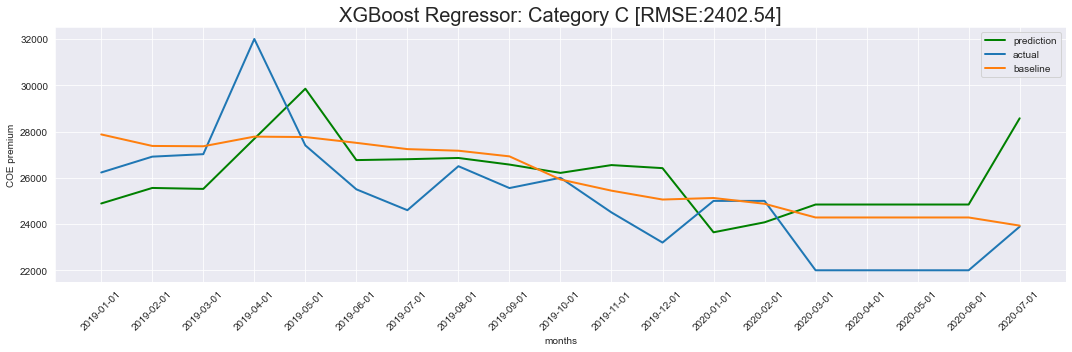

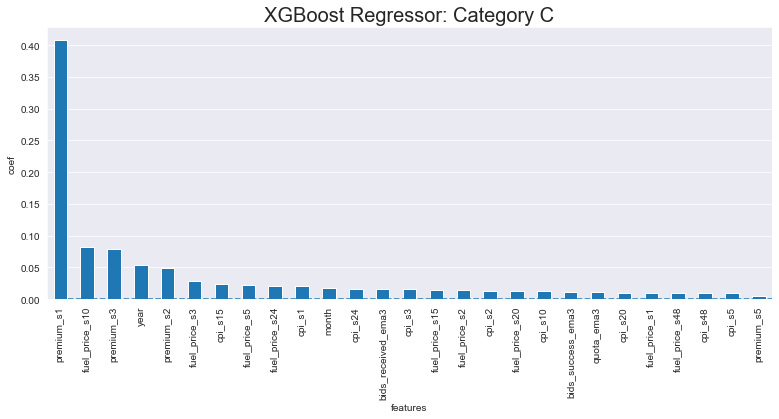

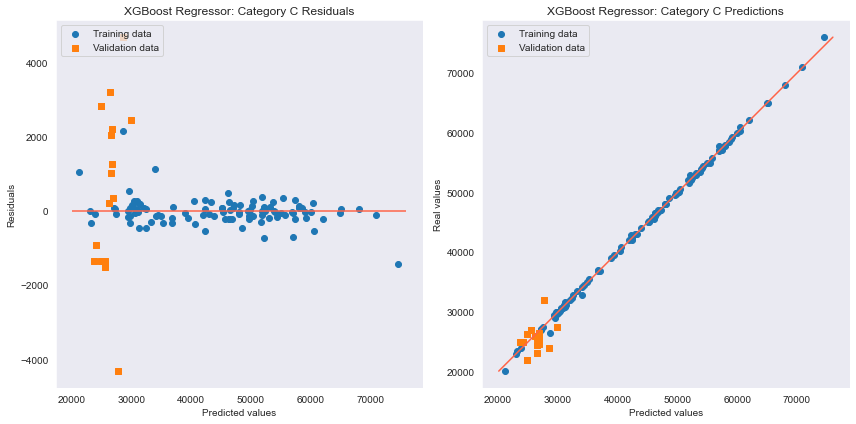

2020-10-14 17:17:11 |WARNING | Consider retraining the model. Last index in train data is 578 days 00:00:00


In [87]:
# XGBoost Regressor for Category C
xgbC = dpm.modelling('xgb','Category C')

In [88]:
# metrics for Category C XGBoost Regressor
results.update(xgbC['results'])
metrics.update(xgbC['metrics'])
display(pd.DataFrame(metrics))

lrA         lrB         lrC        xgbA        xgbB  \
01 Train R2        0.9351      0.9225      0.8619      0.9989      1.0000   
02 Test R2         0.0680      0.2499     -3.4946      0.5755      0.0748   
03 Train RMSE  3,948.7210  4,971.4185  4,458.7876    508.6091     77.6849   
04 Test RMSE   2,674.9417  4,082.5381  5,063.9657  1,805.2177  4,533.8845   
05 Base RMSE   2,100.0304  4,704.9978  1,770.3585  2,100.0304  4,704.9978   
06 Test CV        -1.5745     -1.0743    -12.3922     -1.6776     -0.8324   

                     xgbC  
01 Train R2        0.9991  
02 Test R2        -0.0117  
03 Train RMSE    366.8062  
04 Test RMSE   2,402.5383  
05 Base RMSE   1,770.3585  
06 Test CV        -2.2667

In [89]:
dpm.interpret_xgb('xgb', 'Category C', 2)

Intercept 59974.05391816435
Prediction_local [59420.1603]
Right: 25519.775


In [90]:
dpm.gen_feat_map('xgb', 'Category A', data_files['feat_map'])

<Figure size 3600x1440 with 0 Axes>

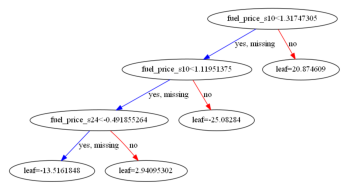

In [91]:
dpm.plot_tree('xgb', 'Category A', data_files['feat_map'], 300);

### Pickle model for deployment

In [92]:
# Pickle model for deployment
pickle.dump(dpm, open(data_files['pickle'], 'wb'))

---
## Predicting forward
In this section we will be looking at the models' performance when predicting at different window sizes

In [93]:
logger.setLevel(logging.INFO)

In [94]:
# Setup parameters for this analysis
n_pred = 12
cat = 'Category C'
cut_off = '2019-01'

### Predicting with window of 6

In [95]:
# preparation of predicting with windown of 6
win_size = 6
dpm.crop_df(cut_off)

In [96]:
win6 = pd.DataFrame()
for i in range(int(n_pred/win_size)):
    dpm.append_dates(dpm.df[cat].index.max(), win_size)
    dpm.train_test_split('xgb', cut_off)
    tmp6 = dpm.modelling('xgb', cat, plot=False)
    win6 = pd.DataFrame(tmp6['results'][f'xgb{cat[-1]}'])
    dpm.update_actual(win_size)
#win6

2020-10-14 17:17:20 |WARNING | Consider retraining the model. Last index in train data is 182 days 00:00:00
2020-10-14 17:17:21 |WARNING | Consider retraining the model. Last index in train data is 365 days 00:00:00


In [97]:
rmse6 = round(dpm.rmse(win6['actual'], win6['pred']),2)
print(f'RMSE score for window size 6: {rmse6}')

RMSE score for window size 6: 2196.76


### Predicting with window of 3

In [98]:
# preparation of predicting with windown of 3
win_size = 3
dpm.crop_df(cut_off)

In [99]:
win3 = pd.DataFrame()
for i in range(int(n_pred/win_size)):
    dpm.append_dates(dpm.df[cat].index.max(), win_size)
    dpm.train_test_split('xgb', cut_off)
    tmp3 = dpm.modelling('xgb', cat, plot=False)
    win3 = pd.DataFrame(tmp3['results'][f'xgb{cat[-1]}'])
    dpm.update_actual(win_size)
#win3

2020-10-14 17:17:23 |WARNING | Consider retraining the model. Last index in train data is 182 days 00:00:00
2020-10-14 17:17:24 |WARNING | Consider retraining the model. Last index in train data is 274 days 00:00:00
2020-10-14 17:17:25 |WARNING | Consider retraining the model. Last index in train data is 365 days 00:00:00


In [100]:
rmse3 = round(dpm.rmse(win3['actual'], win3['pred']),2)
print(f'RMSE score for window size 6: {rmse6}')
print(f'RMSE score for window size 3: {rmse3}')

RMSE score for window size 6: 2196.76
RMSE score for window size 3: 2110.32


### Predicting with window of 1

In [101]:
# preparation of predicting with windown of 1
win_size = 1
dpm.crop_df(cut_off)

In [102]:
win1 = pd.DataFrame()
for i in range(int(n_pred/win_size)):
    dpm.append_dates(dpm.df[cat].index.max(), win_size)
    dpm.train_test_split('xgb', cut_off)
    tmp1 = dpm.modelling('xgb', cat, plot=False)
    win1 = pd.DataFrame(tmp1['results'][f'xgb{cat[-1]}'])
    dpm.update_actual(win_size)
#win1

2020-10-14 17:17:29 |WARNING | Consider retraining the model. Last index in train data is 182 days 00:00:00
2020-10-14 17:17:30 |WARNING | Consider retraining the model. Last index in train data is 212 days 00:00:00
2020-10-14 17:17:30 |WARNING | Consider retraining the model. Last index in train data is 243 days 00:00:00
2020-10-14 17:17:31 |WARNING | Consider retraining the model. Last index in train data is 274 days 00:00:00
2020-10-14 17:17:32 |WARNING | Consider retraining the model. Last index in train data is 304 days 00:00:00
2020-10-14 17:17:33 |WARNING | Consider retraining the model. Last index in train data is 335 days 00:00:00
2020-10-14 17:17:33 |WARNING | Consider retraining the model. Last index in train data is 365 days 00:00:00


In [103]:
rmse1 = round(dpm.rmse(win1['actual'], win1['pred']),2)
print(f'RMSE score for window size 6: {rmse6}')
print(f'RMSE score for window size 3: {rmse3}')
print(f'RMSE score for window size 1: {rmse1}')

RMSE score for window size 6: 2196.76
RMSE score for window size 3: 2110.32
RMSE score for window size 1: 2095.85


We can see the RMSE score increase slightly as the window size increases. So depending on the application or business case, we can predict with a different window size.

---
## Conclusions


We began this project with 46 files and that quickly got reduced to 6 files which eventually left us with less than 10 features. 
Some challenges on working with real world data on top of the usual data cleaning are:
- Finding data that are available within the same time frame, for example time frame of interest is between 2010 to 2020, datasets available may be from 2018 to 2020, or 2000 to 2012.
- Finding data that are in the same granularity, for example when most datasets are in monthly, how to fit daily or weekly data together 
- Finding data that are categorized/grouped/labeled for your problem, for example COE categories vs CC vs Make vs passenger capacity. 

With limited features available, the first model we tried was Classic Time Series model ARIMA. Although the target, premium was not stationary we have taken premium's diff order 1 for ARIMA and GridSearched resulting with an order of (1,0,2). However ARIMA did not yield a very good predict.

Since the time series models are out, next step was to look into feature engineering to increase the number of features for the other models that we are going to try. In feature engineering, there are two main groups that we created are shifted and EWMA features.
- Shifted features, these are the features where values in the past have an impact to our target. Features that are shifted were ['cpi', 'fuel_price', 'dereg', 'premium'], and these are shifted by [1, 2, 3, 5, 10, 15, 20, 24, 48]. 
- EWMA Features, exponentially weighted moving average is a moving average where higher weights are given to the values that are nearer. Features that are EWMA are ['quota', 'bids_success', 'bids_received'] and they are applied on EWMA 3.

Now that we have more features, ~45 features. We will use linear regression to analyze the features that has impact on the target. From the initial linear regression we were hitting RMSE of ~12K, after regularization and iterations of tuning. We were able to achieve RMSE for ~8K. 

Below is the top 3 features for each category from our Linear regression:
![model metrics](../images/top_features.jpg)
The top 3 features, premium_s1, quota_ema3 and bids_success_ema3 are consistent for both Category A and B. For Category C, quota_ema3 and bids_success_ema3 are on the 4th and 5th position which has significant impact on the target as well.

Next we moved on to XGBoost Regressor to see if we can improve the RMSE further. While tuning the XGBoost Regressor we realised that using a single model and a single set was not helping. Hence we created models for each category along with it's own set of features. After many iterations of hyperparameters tuning and features selection for each model, we were able to achieve RMSE ~5K. 
<br>
The final model metrics are as shown below:
![model metrics](../images/metrics.jpg)

prefix **lr** are Linear Regression model, the last character indicates the COE category<br>
prefix **xgb** are XGBoost Regressor model, the last character indicates the COE category

Although we have achieved a RMSE of < 5K, these models are far from perfect.
In this project we have only scratch the surface of putting together a model to predict the COE premium.
There are many more factors that affects COE prices. As with all corporate projects it is always a balance of Scope, Time and Cost. Projects have to be scoped in a way that it meets the business requirements, delivered on time and within cost.

### Limitations of the models

The limitations of the models:
- Limited data time frame, for this project the time frame we were looking at is from 2010 to 2020. While we were able to achieve a reasonable good RMSE, COEs have a lifespan of 10 years this 10 year cycle would not be picked up by the models. For that to happen, we should have data to contain at least a few cycles. This should help in the case of the ARIMA models as well.
- Limited data, without feature engineering we had only a handful of features. It will be good to collect more data and include more features for the analysis. 
- Take events into account, for example Covid and Financial Crisis

---
## Recommendations

Some recommendations to further improve the models:
- Get more data 
    - in terms of time frame, should get data that captures at least 3 to 4 cycles. For this case COE started in 1990 so should get the full data if possible.
    - in terms of features, household income and unemployment rate
- Encoding events into features
    - MAS loan restrictions (When tighten or ease loan restrictions)
    - LTA annouce growth rate changes (LTA increase/decrease growth)
    - Car launches/events (Major car launches or event, where discount and incentives entices buyers)
    - Vehicular Emissions Scheme ()
- With more data we can also try Auto ARIMA
- Sentiment of owning a car